# Исследовательский анализ данных для выпускного проекта

**Описание проекта**

Необходимо обучить модель для прогнозирования оттока клиентов, с целью определения и удержания таких клиентов за счёт специальных предложений.


**Цель:** Согласно требований заказчика необходимо построить модель машинного обучения, которая предскажет отток клиентов компании, оказывающей услуги телеком оператора, с качеством по `ROC-AUC` метрике `≥ 0.88`.



**Задачи:**
1. Провести исследовательский анализ данных.
2. Создать дополнительные признаки и подготовить данные к обучению.
3. Обучить различные модели, провести сравнительный анализ моделей по выбранной метрике качества, выбрать лучшую модель.
4. Провести анализ ошибок работы лучшей модели.
5. Сделать выводы.


**Описание данных:**

Данные представлены в 4 файлах и содержат следующую информацию:


* `contract.csv` — информация о договорах с клиентами
* `personal.csv` — персональные данные клиентов
* `internet.csv` — информация об интернет-услугах
* `phone.csv` — информация об услугах телефонии

В процессе изучения данных установлены представленные в них показатели.

В `contract.csv` представлена информация о договорах:

* `customerID` - уникальный ID клиента
* `BeginDate` - дата заключения договора
* `EndDate` - дата расторжения договора
* `Type` - тип оплаты за услуги (ежемесячный платёж или раз в год, несколько лет)
* `PaperlessBilling` - получает ли клиент электронный чек
* `PaymentMethod` - способы оплаты за услуги
* `MonthlyCharges` - ежемесячные платежи независимо от типа оплаты
* `TotalCharges` - общая сумма платежей клиента

В `personal.csv` представлена информация о самих клиентах:

* `customerID` - уникальный ID клиента
* `gender` - пол клиента
* `SeniorCitizen` - является ли клиент пенсионером
* `Partner` - есть ли у клиента партнёр
* `Dependents` - наличие детей на иждивении

В `internet.csv` представлена информация об интернет-услугах:

* `customerID` - уникальный ID клиента
* `InternetService` - варианты подключения интернет-соединения
* `OnlineSecurity` - услуга блокировки небезопасных сайтов 
* `OnlineBackup` - услуга облачного хранилища файлов
* `DeviceProtection` - наличие услуги антивируса
* `TechSupport` - услуга выделенной линии технической поддержки
* `StreamingTV` - услуга стримингового телевидения
* `StreamingMovies` - услуга каталога фильмов 

В `phone.csv` представлена информация об услугах телефонии:

* `customerID` - уникальный ID клиента
* `MultipleLines` - мультиканальная линия или нет (в данном случае отдельно услуга телефона связи или вместе с интернетом)

## Загрузка и анализ данных

### Импорт библиотек

Подключим необходимые для работы библиотеки:
* `pandas` - для работы с таблицами;
* `numpy` - для операций над массивами;
* `seaborn` - для визуализации данных;
* `sklearn` - для препроцессинга данных, вычисления интересующих метрик и создания *baseline* моделей;
* `catboost`, `lightgbm` - для создания моделей на основе градиентного бустинга.

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score

from typing import Union

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_importance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

C:\Users\Oleg\anaconda3\envs\ds\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#!pip install phik

In [3]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

Зададим начальное значение генератора псевдослучайных чисел для вопроизводимости полученных в исследовании результатов.

In [4]:
# начальное значение генератора псевдослучайных чисел
RND = 290822

# количество фолдов на кроссвалидации
CV_FOLDS = 5

### Загрузка и обзор полученных данных

Загрузим csv-файлы `contract.csv`, `internet.csv`, `personal.csv` и `phone.csv`, в которых находятся предоставленные для исследования данные и проведём их предварительную оценку. Посмотрим на общий вид табличных данных, сводную информацию и проверим количество пропущенных значений в исследуемых таблицах.

Так как во всех четырёх таблицах, судя по предоставленной информации, присуствует признак `customerID` - уникальный ID клиента, то данный атрибут целесообразно использовать в качестве индексов.

In [5]:
# чтение файлов contract.csv, internet.csv, personal.csv и phone.csv на два случая 
# (из директории Яндекса и с локального окружения) 
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')
except FileNotFoundError:
    df_contract = pd.read_csv('./datasets/final_provider/contract.csv', index_col='customerID')
    df_internet = pd.read_csv('./datasets/final_provider/internet.csv', index_col='customerID')
    df_personal = pd.read_csv('./datasets/final_provider/personal.csv', index_col='customerID')
    df_phone = pd.read_csv('./datasets/final_provider/phone.csv', index_col='customerID')

Для удобства вывода различных данных о таблицах, а также избежания дублирования кода при его многократном использовании в однотипных операциях создадим вспомогательные функции *print_tab_row()* и *data_exploration()*.

In [6]:
# вспомогательная функция вывода данных в табличной форме
def print_tab_row(descr:str, 
                  value:str, 
                  total_width=95, 
                  col_1_format='| {: <80}|', 
                  col_2_format='{: >10.2f} |', 
                  b_line=True) -> None:
    """
    input:        descr (str)        - строка-описание выводимой информации
                  value (int, float) - значение отображаемого параметра
                  total_width (int)  - общая ширина таблицы
                  col_1_format (str) - формат первого столбца
                  col_2_format (str) - формат второго столбца
                  b_line (bool)      - отрисовывание нижней границы
    output: None
    description:  Функция принимает на вход параметры и выводит в табличной форме различные данные
    """
    print('-' * total_width)
    print(col_1_format.format(descr), end='')
    print(col_2_format.format(value))
    if b_line:
        print('-' * total_width)
    return None

In [7]:
# вспомогательная функция для анализа данных
def data_exploration(df:pd.DataFrame, title:str) -> None:
    """
    input:        df (pd.DataFrame)  - анализируемый датафрейм
                  title (str)        - название анализируемого датафрейма
    output: None
    description:  Функция принимает на вход датафреймы и выводит основную информацию о них
    """
    if(title=='Contract dataframe'):
        print_tab_row(f'***** {title.upper()} *****', '', col_1_format='| {: ^89} ', col_2_format='{: >1} |', b_line=False)
        print_tab_row(f'Количество полных дубликатов:', df.duplicated().sum(), col_2_format='{: >10d} |')
    else:
        print_tab_row(f'***** {title.upper()} *****', '', col_1_format='| {: ^89} ', col_2_format='{: >1} |', b_line=True)
    # просмотр первых строк из таблицы
    display(df.head(5))
    print('\n')
    # вывод общей информации о датафрейме
    df.info()
    print('\n')
    # подсчёт количества пропущенных значений
    display(df.isna().sum())
    print('\n\n')
    return None

In [8]:
# подготовка списков датафреймов и их названий для анализа
dfs = [df_contract, df_internet, df_personal, df_phone]
titles = ['Contract dataframe', 'Internet dataframe', 'Personal dataframe', 'Phone dataframe']

In [9]:
# перебор датафреймов и их названий с последующим анализом с помощью функции data_exploration
for df, title in zip(dfs, titles):
    data_exploration(df, title)

-----------------------------------------------------------------------------------------------
|                              ***** CONTRACT DATAFRAME *****                                 |
-----------------------------------------------------------------------------------------------
| Количество полных дубликатов:                                                   |        45 |
-----------------------------------------------------------------------------------------------


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB




BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64




-----------------------------------------------------------------------------------------------
|                              ***** INTERNET DATAFRAME *****                                 |
-----------------------------------------------------------------------------------------------


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No




<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB




InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64




-----------------------------------------------------------------------------------------------
|                              ***** PERSONAL DATAFRAME *****                                 |
-----------------------------------------------------------------------------------------------


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No




<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB




gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64




-----------------------------------------------------------------------------------------------
|                                ***** PHONE DATAFRAME *****                                  |
-----------------------------------------------------------------------------------------------


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes




<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB




MultipleLines    0
dtype: int64

> * Данные успешно загружены из файлов `contract.csv`, `internet.csv`, `personal.csv` и `phone.csv`.
> * Во всех файлах обнаружено нарушение змеиного стиля в названиях столбцов. Для последующей работы с данными следует выполнить преобразование названий атрибутов из `CamelCase` в `snake_case`.
>     * В файле с информацией о договорах `contract.csv`:
>         * содержится `7043` объекта, пропущенных значений нет, обнаружено `45` дубликатов, которые необходимо проанализировать;
>         * атрибуты `BeginDate` и `EndDate` для удобства работы целесообразно преобразовать в формат `datetime`;
>         * атрибут `EndDate` - дата расторжения договора будет являться целевым признаком для чего потребуется его бинаризация по принципу если отмечена дата ухода клиента, то присваиваем такому клиенту метку `1`, в противном случае метку `0`;
>         * категориальные признаки `Type` (тип оплаты за услуги), `PaperlessBilling` (получает ли клиент электронный чек) и `PaymentMethod` (способы оплаты за услуги) для моделей, которые не могут с ними работать в существующем виде необходимо будет закодировать числовыми значениями;
>         * атрибут `TotalCharges` привести к числовому типу данных `float64`.
>     * В файле с информацией об интернет-услугах `internet.csv`:
>         * содержится `5517` объектов, пропущенных значений нет, проверять наличие дубликатов из-за особенностей данных нецелесообразно;
>         * объектов в данных об интернет-услугах меньше, чем общее количество договоров, что означает то, что не все клиенты ими пользуются;
>         * категориальный признак `InternetService` (варианты подключения интернет-соединения)  для моделей, которые не смогут с ним работать в существующем виде необходимо будет закодировать числовыми значениями;
>         * атрибуты `OnlineSecurity` (услуга блокировки небезопасных сайтов), `OnlineBackup` (услуга облачного хранилища файлов), `DeviceProtection` (наличие услуги антивируса), `TechSupport` (услуга выделенной линии технической поддержки), `StreamingTV` (услуга стримингового телевидения) и `StreamingMovies` (услуга каталога фильмов), являющиеся по своей сути бинарными, необходимо преобразовать к значениям `0` и `1`.
>     * В файле с информацией о клиентах `personal.csv`:
>         * содержится `7043` объекта, пропущенных значений нет, проверять наличие дубликатов из-за особенностей данных нецелесообразно;
>         * количество данных о клиентах соотвествует количеству договоров, следовательно потерь данных об отдельных клиентах на данном этапе нет;
>         * атрибуты `gender` (пол клиента), `Partner` (есть ли у человека партнёр) и `Dependents` (наличие детей на иждивении) необходимо преобразовать к значениям `0` и `1`.
>     * В файле с информацией об услугах телефонии `phone.csv`:
>         * содержится `6361` объект, пропущенных значений нет, проверять наличие дубликатов из-за особенностей данных нецелесообразно;
>         * объектов в данных об услугах телефонии меньше, чем общее количество договоров, но больше чем в данных об интернет-услугах;
>         * атрибут `MultipleLines` (мультиканальная линия или нет) целесообразно преобразовать к значениям `0` и `1`.

### Исследовательский анализ данных

#### Анализ обнаруженных дубликатов в датафрейме df_contract

Оценим визуально найденные дубликаты в датафрейме `df_contract`.

In [10]:
# просмотр первых строк дубликатов в датафрейме df_contract
df_contract.loc[df_contract.duplicated()].head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7617-EYGLW,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
4291-HPAXL,2020-01-01,No,Month-to-month,No,Mailed check,19.85,19.85
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55
2812-SFXMJ,2020-01-01,No,Month-to-month,No,Mailed check,20.05,20.05
3247-MHJKM,2020-01-01,No,Month-to-month,No,Mailed check,20.20,20.2
1942-OQFRW,2020-01-01,No,Month-to-month,No,Electronic check,44.00,44
5996-DAOQL,2020-01-01,No,Month-to-month,Yes,Mailed check,20.45,20.45
0415-MOSGF,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,44.40,44.4
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45


Судя по визуальной оценке, дубликаты образованы в результате случайного совпадения данных. Чтобы проверить данную гипотезу, посмотрим на количество уникальных пользователей по индексам `customerID`. Если их общее количество совпадёт с количеством пропущенных значений (`45`), то гипотезу можно будет принять.

In [11]:
# просмотр количества уникальных значений индексов customerID
df_contract.loc[df_contract.duplicated()].index.nunique()

45

Количество уникальных индексов `customerID` совпало с количеством пропущенных значений, поэтому принимаем гипотезу о том, что совпадения, определённые как дубликаты, имеют случайный характер. Поэтому, оставим эти данные как есть.

#### Объединение данных в сводной таблице

Для удобства работы и последующего анализа данных объединим все таблицы в общий датафрейм по индексам `customerID`.

In [12]:
# объединение данных в единый датафрейм
df = (df_contract.merge(df_internet, on =['customerID'], how='left')
      .merge(df_personal, on =['customerID'], how='left')
      .merge(df_phone, on =['customerID'], how='left')
     )

In [13]:
# просмотр информации о сводном датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null 

Выполним намеченные в ходе обзора данных шаги по предобработке данных. Начнём с преобразования названий атрибутов из `CamelCase` в `snake_case`.

In [14]:
# преобразование наименований признаков
df = df.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())

In [15]:
# проверка результата преобразования
df.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines'],
      dtype='object')

Преобразование проведено корректно. Все наименования атрибутов теперь представлены в `snake_case` стиле.

Преобразуем атрибут `total_charges` к типу данных `float64`. Этому будут мешать несколько значений в виде строк с пробелом из-за которых этот атрибут и был приведён к типу `object`. Оценим количество подобных значений.

In [16]:
# оценка количества значений с пробелом в атрибуте «total_charges»
print_tab_row(
    'Количество значений с пробелом в атрибуте «total_charges»:', 
    df.loc[df['total_charges']==' '].shape[0],
    col_2_format='{: >10d} |'
)

-----------------------------------------------------------------------------------------------
| Количество значений с пробелом в атрибуте «total_charges»:                      |        11 |
-----------------------------------------------------------------------------------------------


Данных с пробелом в атрибуте `total_charges` менее одного процента (`0.16%`). Проведём визуальную оценку пропущенных значений.

In [17]:
# вывод данных с пропущенными значениями по общим платежам total_charges для их визуальной оценки
df.loc[df['total_charges']==' ']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No


Анализ пропущенных значений показал, что все клиенты, по которым присутствуют пропущенные значения по данному показателю, заключили договор в дату выгрузки данных. Соотвественно, логичным решением выглядит заполнение пропущенных значений атрибута `total_charges` значениями `monthly_charges`, относящихся к данным клиентам.

In [18]:
# заполнение значений с пробелом в «total_charges» медианным значением
df.loc[df['total_charges'] == ' ', 'total_charges'] = df.loc[df['total_charges'] == ' ', 'monthly_charges']

После замены значений с пробелом в `total_charges` можно преобразовать к типу данных `float64`. 

In [19]:
# преобразование total_charges к типу данных float64
df['total_charges'] = df['total_charges'].astype('float64')

Преобразуем атрибут `begin_date` для удобства работы в формат `datetime`.

In [20]:
# преобразование атрибутов begin_date и end_date в формат datetime
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

Посмотрим на период за который представлены данные. Для этого определим минимальное значение атрибута `begin_date` и максимальное `end_date`.

In [21]:
# просмотр минимальное значения атрибута «begin_date» и максимального «end_date»
print_tab_row(
    'Начальное значение даты в «begin_date»:', 
    str(df['begin_date'].min())[:10],
    col_1_format='| {: <79}|',
    col_2_format='{: >11} |',
    b_line=False
)
print_tab_row(
    'Конечное значение даты в «begin_date»:', 
    str(df['begin_date'].max())[:10],
    col_1_format='| {: <79}|',
    col_2_format='{: >11} |'
)

-----------------------------------------------------------------------------------------------
| Начальное значение даты в «begin_date»:                                        | 2013-10-01 |
-----------------------------------------------------------------------------------------------
| Конечное значение даты в «begin_date»:                                         | 2020-02-01 |
-----------------------------------------------------------------------------------------------


Данные о телекоммуникационной компании представлены за `6` лет и `3` месяца с `октября 2013` года по `февраль 2020`.

Создадим дополнительный признак `client_off` в виде количества месяцев в течение которых клиенты пользовались или продолжают пользоваться услугами. Для этого продублируем информацию, которую содержит столбец `end_date` и для всех значений `No` установим метку `0` - клиент не ушёл, а для остальных метку `1` - клиент прекратил пользоваться услугами и расторг контракт. Полученный признак будет являться целевым.

Для самого атрибута `end_date` изменим тип данных на `datetime`, пропуски заполним сначала значениями `NaN`, а затем максимальным значением даты в данных.

In [22]:
# дублирование признака end_date и создание на его основе целевого признака
df['client_off'] = np.where(df['end_date'] == 'No', 0, 1)
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')
df['end_date'] = df['end_date'].fillna(df['begin_date'].max())
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Проанализируем данные о дате ухода клиентов из компании. Для этого изучим распределение дат ухода клиентов.

In [23]:
# просмотр распределения дат ухода клиентов
(
    pd.DataFrame(df.loc[df['client_off'] != 0, 'end_date'].value_counts())
    .rename(columns={'end_date': 'client_off_count'})
    .sort_index()
    .style.bar()
)

,client_off_count
2019-10-01 00:00:00,458
2019-11-01 00:00:00,485
2019-12-01 00:00:00,466
2020-01-01 00:00:00,460


На основе известных начальной `begin_date` и конечной дат `end_date_copy` создадим дополнительные признаки:
* `days_count` общее количество дней, в течение которых клиент пользуется/пользовался услугами оператора;
* `months_count`- общее количество месяцев, в течение которых клиент являлся или продолжает являться пользователем услуг.

In [24]:
# создание дополнительного признака в виде количества месяцев в течение которых клиент являлся или продолжает
# являться пользователем услуг
df['days_count'] = (df['end_date'] - df['begin_date']).astype('timedelta64[D]').astype('int64')
df['months_count'] = (df['end_date'] - df['begin_date']).astype('timedelta64[M]').astype('int64')

Так как было уточнено, что если данные по использованию интернет услуг и телефонии отсутствуют, то это означает, что клиент не использует эти услуги, следовательно можно заполнить все пропуски значением `No`. Для этого сохраним в список названия всех столбцов с пропущенными значениями и далее перебором этого списка заполним пропущенные значения.

In [25]:
# получение списка столбцов с пропущенными значениями
columns_with_missing_values = []
for column in df.columns:
    if df[column].isna().sum() > 0:
        columns_with_missing_values.append(column)

In [26]:
# заполнение пропущенных значений
for column in columns_with_missing_values:
    df[column] = df[column].fillna('No')

Проверим полноту заполнения пропущенных значений по различным столбцам.

In [27]:
# просмотр информации о сводном датафрейме после заполнения пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   internet_service   7043 non-null   object        
 8   online_security    7043 non-null   object        
 9   online_backup      7043 non-null   object        
 10  device_protection  7043 non-null   object        
 11  tech_support       7043 non-null   object        
 12  streaming_tv       7043 non-null   object        
 13  streaming_movies   7043 non-null   object        
 14

Все пропущенные значения по различным столбцам на данном этапе заполнены.

> * Для удобства работы и последующего анализа данных все таблицы из четырёх файлов объединены в общий датафрейм по индексам `customerID`.
> * В полученной сводной таблице нарушения змеиного стиля в названиях столбцов устранены преобразованием названий атрибутов из `CamelCase` в `snake_case`.
> * Установлено, что данные телекоммуникационной компании о клиентах представлены за период `6` лет и `3` месяца - с `октября 2013` года по `февраль 2020`.
> * Отток клиентов зафиксирован в последние четыре месяца и происходил по первым числам каждого месяца. Таким образом, дата расторжения договора представлена всего четырьмя уникальными датами с равномерным распределением количества ушедших клиентов между ними.
> * Исходя из предыдущего пункта, корректность предоставленных данных нуждается в уточнении. Пока же будет проведена работа с уже имеющимимся данными.

#### Оценка распределения значений признаков, выявление пропусков и аномалий

##### Целевой признак `client_off`

Оценку распределений начнём с целевого признака `client_off` - факта ухода клиента и прекращения использования им услуг компании.

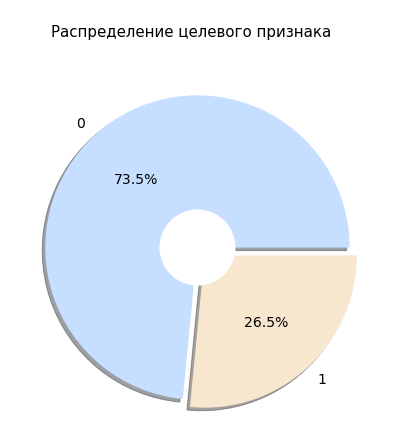

In [28]:
# построение графика распределения целевого признака
client_off = df['client_off'].value_counts()

colors = ['#C6DEFF', '#F7E7CE']

fig = plt.figure(figsize = (7, 7))
fig.suptitle('\nРаспределение целевого признака', fontsize=15)
plt.pie(
    client_off,
    labels = client_off.index,
    autopct='%.1f%%',
    textprops={'fontsize': 14},
    explode=(0, 0.07),
    colors=colors,
    shadow=True
)
centre_circle = plt.Circle((0,0),0.25,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show();

> * Ушедших клиентов `26.5%`, то есть каждый четвёртый. Показатель достаточно высокий и он объясняет озабоченность оператора связи оттоком клиентов.

##### Количество дней в статусе клиента `days_count`

Для анализа количественных переменных создадим вспомогательную функцию *num_feature_research()*, которая будет выводить основные описательные статистики исследуемого атрибута с разделением по классам целевой переменной, а также построит диаграмму размаха и гистограмму распределения частот для изучаемого признака.

In [29]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def num_feature_research(feature:str, chart_title:str, x_lims=(0, 100), discrete=False) -> None:    
    """
    input: feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           x_lims (tuple)       - диапазон значений по оси X
           discrete (bool)      - избегать пробелов в случае дискретных значений по оси Х
    output: None
    description: Функция принимает input параметры, выводит таблицу с описательными статистиками, строит диаграмму 
                 размаха и графики распределение частот для исследуемого признака
    """
    print(f'Признак: «{feature}» класс «0»')
    display(df.loc[df['client_off']==0, feature].describe())
    print()
    print(f'Признак: «{feature}» класс «1»')
    display(df.loc[df['client_off']==1, feature].describe())
    print()
    
    sns.set()
    sns.set_palette(palette='muted')
    
    f, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw=dict(height_ratios=[1, 4]))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(f'\nГрафик распределения признака «{feature}» \n {chart_title}\n', fontsize=17)
    axes[0] = sns.boxplot(x=df[feature], y=df['client_off'], orient='h', ax=axes[0])
    axes[0].set_xlim(x_lims)
    axes[0].set_xticklabels([])
    


    axes[1].set_ylabel('', fontsize=14)
    axes[1] = sns.histplot(
        data=df,
        x=feature,
        hue=df['client_off'],
        alpha=0.3,
        ax=axes[1],
        kde=True,
        discrete=discrete,
        bins=75
    )
    axes[1].set_ylabel('Частота встречаемости', fontsize=14)
    axes[1].set_xlabel(chart_title, fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();
    
    return None

Воспользуемся созданной функцией *num_feature_research()* и проведём анализ распределения и основных описательных статистик признака количество дней в статусе клиента `days_count`.

Признак: «days_count» класс «0»


count    5174.000000
mean     1144.447236
std       733.897937
min         0.000000
25%       457.000000
50%      1157.000000
75%      1857.000000
max      2191.000000
Name: days_count, dtype: float64


Признак: «days_count» класс «1»


count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: days_count, dtype: float64

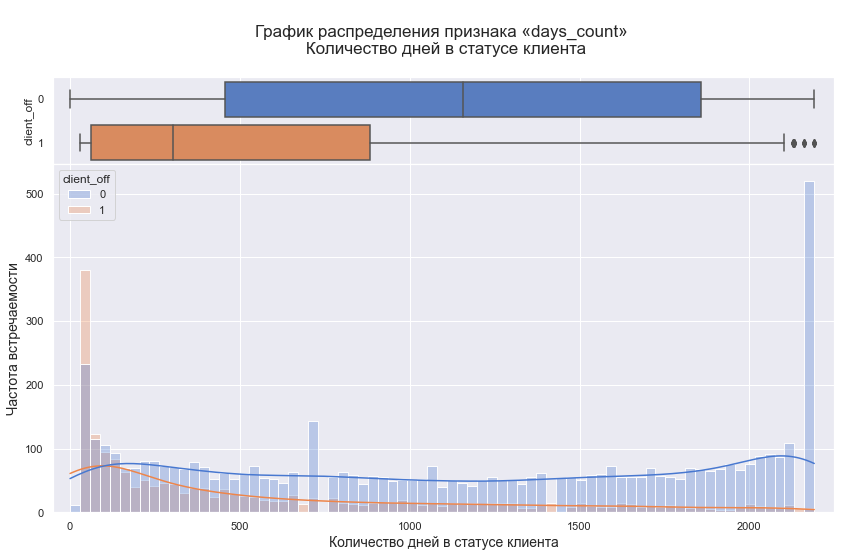

In [30]:
# оценка распределения признака количество дней в статусе клиента
num_feature_research('days_count', 'Количество дней в статусе клиента', x_lims=(-50, 2250))

> * Распределение признака количество дней в статусе клиента характеризуется для ушедших клиентов медианным значением `304` и средним `547.4`, для продолжающих оставаться клиентами медианным значением `1157` и средним `1144.4`.
> * Несмотря на значимые отличия в среднем и медианном значениях, чёткого разделения распределений между ушедшими клиентами и продолжающими ими оставаться нет. Есть лишь общая тенденция, что с увеличением количества дней в статусе клиента доля ушедших клиентов стабильно снижается.

##### Количество месяцев в статусе клиента `months_count`

Проведём анализ распределения и основных описательных статистик признака количество месяцев в статусе клиента `months_count`.

Признак: «months_count» класс «0»


count    5174.000000
mean       37.433127
std        24.029399
min         0.000000
25%        15.000000
50%        38.000000
75%        61.000000
max        71.000000
Name: months_count, dtype: float64


Признак: «months_count» класс «1»


count    1869.000000
mean       17.588015
std        19.489864
min         0.000000
25%         2.000000
50%         9.000000
75%        29.000000
max        71.000000
Name: months_count, dtype: float64

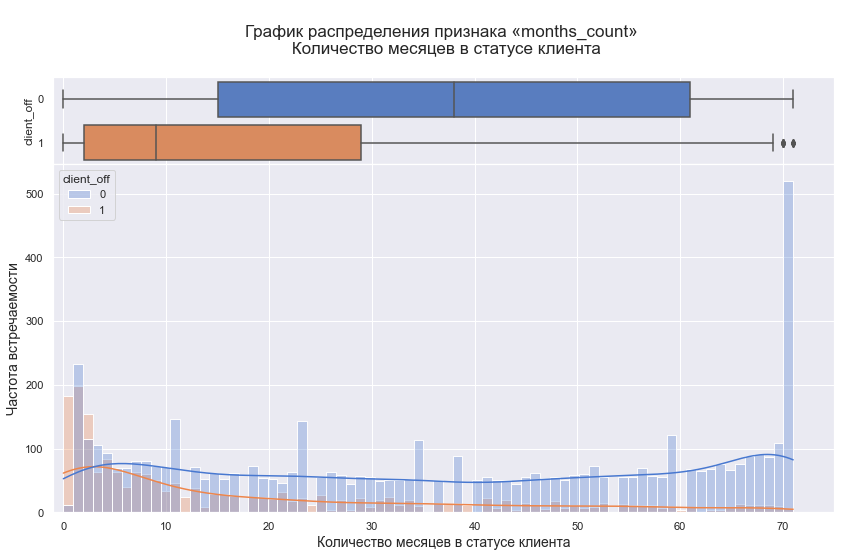

In [31]:
# оценка распределения признака количество месяцев в статусе клиента
num_feature_research('months_count', 'Количество месяцев в статусе клиента', x_lims=(-1, 75))

> * Распределение признака количество месяцев в статусе клиента характеризуется для ушедших клиентов медианным значением `9` и средним `17.6`, для продолжающих оставаться клиентами медианным значением `38` и средним `37.4`.
> * Несмотря на значимые отличия в среднем и медианном значениях, чёткого разделения распределений между ушедшими клиентами и продолжающими ими оставаться нет. Есть лишь общая тенденция, что с увеличением количества месяцев в статусе клиента доля ушедших клиентов стабильно снижается.

##### Ежемесячные платежи `monthly_charges`

Оценим распределение значений по ежемесячным платежам `monthly_charges` для клиентов различных классов.

Признак: «monthly_charges» класс «0»


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthly_charges, dtype: float64


Признак: «monthly_charges» класс «1»


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthly_charges, dtype: float64

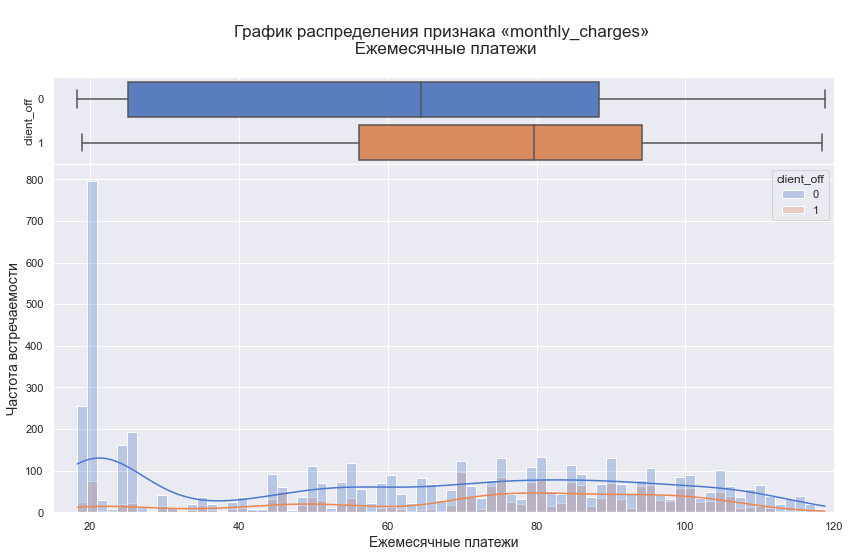

In [32]:
# оценка распределения признака по ежемесячным платежам
num_feature_research('monthly_charges', 'Ежемесячные платежи', x_lims=(15, 120))

> * Распределение признака по ежемесячным платежам характеризуется для ушедших клиентов медианным значением `79.6` и средним `74.4`, для продолжающих оставаться клиентами медианным значением `64.4` и средним `61.3`.
> * Ушедшие клиенты ежемесячно платили больше продолжающих оставаться клиентами. В целом, распределения по данному признаку между клиентами различных классов пересекаются на всём диапазоне значений от минимума до максимума и не демонстрируют какого-либо выраженного разделения.

##### Общая сумма платежей `total_charges`

Оценим распределение значений по общей сумме платежей `total_charges` для клиентов различных классов.

Признак: «total_charges» класс «0»


count    5174.000000
mean     2549.999497
std      2329.858843
min        18.800000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: total_charges, dtype: float64


Признак: «total_charges» класс «1»


count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: total_charges, dtype: float64

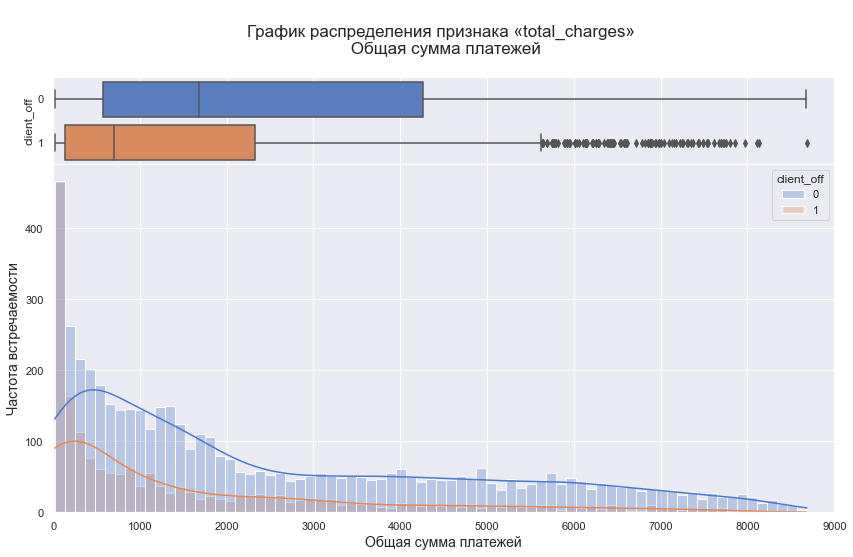

In [33]:
# оценка распределения признака по общей сумме платежей
num_feature_research('total_charges', 'Общая сумма платежей', x_lims=(0, 9000))

> * Распределение признака по общей сумме платежей характеризуется для ушедших клиентов медианным значением `703.6` и средним `1531.8`, для продолжающих оставаться клиентами медианным значением `1679.5` и средним `2552.9`.
> * В отличие от ежемесячных платежей, общая сумма платежей для ушедших клиенты оказалась меньшей, чем для продолжающих оставаться клиентами. Распределения значений по данному признаку по форме соотвествуют распределению Пуассона и пересекаются на всём диапазоне значений от минимума до максимума и не демонстрируя какого-либо выраженного разделения.

##### Корреляция количественных признаков

Посмотрим как количественные признаки коррелируют между собой, с разделением на ушедших клиентов и продолжающих оставаться лояльными. Для этой цели построим график `pairplot`.

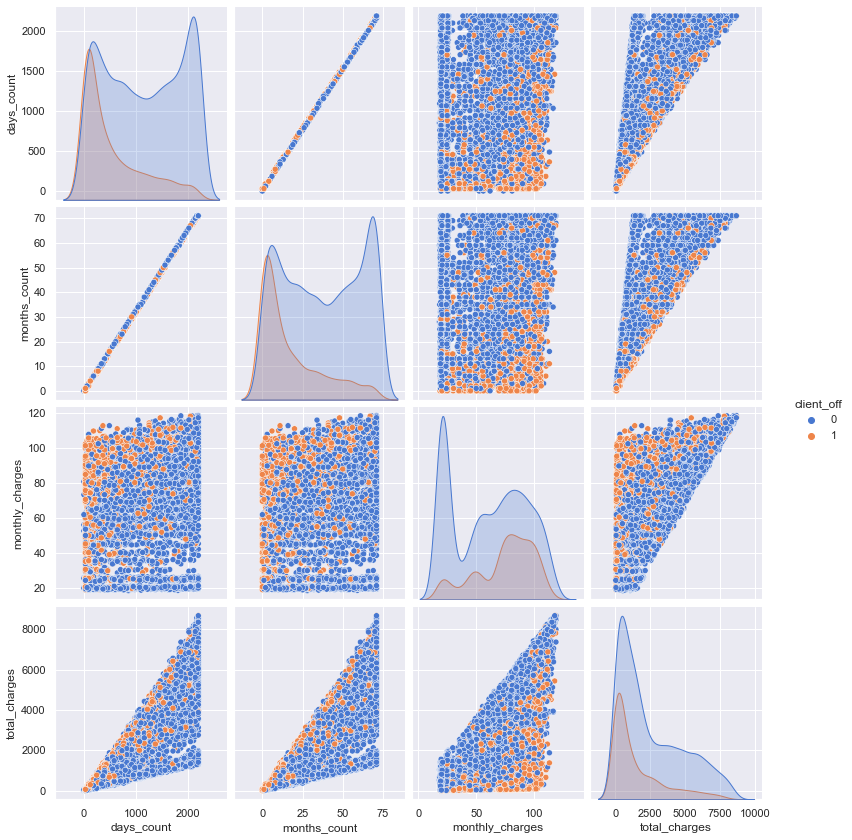

In [34]:
# построение pairplot для количественных принаков
sns.pairplot(
    df[['days_count', 'months_count', 'monthly_charges', 'total_charges', 'client_off']], hue='client_off'
).fig.set_size_inches(12, 12)

Также отобразим корреляцию признаков в табличной форме.

In [35]:
# построение матрицы корреляции
df[['days_count', 'months_count', 'monthly_charges', 'total_charges']].corr()

,days_count,months_count,monthly_charges,total_charges
days_count,1.000000,0.999879,0.247754,0.826095
months_count,0.999879,1.000000,0.246214,0.825192
monthly_charges,0.247754,0.246214,1.000000,0.651182
total_charges,0.826095,0.825192,0.651182,1.000000


Оценим также величину нелинейных корреляций и корреляций с категориальными переменным. Для этого воспользуемся специальным коэффициентов корреляции `φk` из библиотеки `phik`, и построим матрицу корреляций для исследуемых данных.

In [36]:
# получение матрицы φk-корреляций
phik_overview = df.drop(['begin_date', 'end_date'], axis=1).phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'client_off', 'days_count', 'months_count']


,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,client_off,days_count,months_count
type,1.00,0.11,0.28,0.39,0.51,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.00,0.09,0.18,0.15,0.07,0.25,0.66,0.66
paperless_billing,0.11,1.00,0.37,0.47,0.21,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.00,0.24,0.01,0.17,0.25,0.30,0.00,0.00
payment_method,0.28,0.37,1.00,0.40,0.35,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.00,0.29,0.24,0.22,0.34,0.45,0.38,0.37
monthly_charges,0.39,0.47,0.40,1.00,0.76,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.01,0.30,0.20,0.18,0.68,0.36,0.41,0.41
total_charges,0.51,0.21,0.35,0.76,1.00,0.51,0.54,0.66,0.67,0.57,0.66,0.67,0.00,0.15,0.42,0.11,0.61,0.28,0.84,0.84
internet_service,0.51,0.23,0.32,0.92,0.51,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.00,0.16,0.00,0.11,0.23,0.20,0.02,0.00
online_security,0.15,0.00,0.26,0.55,0.54,0.24,1.00,0.43,0.42,0.53,0.27,0.29,0.02,0.06,0.22,0.12,0.15,0.26,0.42,0.42
online_backup,0.10,0.20,0.28,0.63,0.66,0.23,0.43,1.00,0.46,0.45,0.43,0.42,0.01,0.10,0.22,0.03,0.31,0.13,0.47,0.46
device_protection,0.14,0.16,0.31,0.67,0.67,0.23,0.42,0.46,1.00,0.50,0.58,0.59,0.00,0.09,0.24,0.01,0.31,0.10,0.47,0.47
tech_support,0.18,0.06,0.27,0.58,0.57,0.24,0.53,0.45,0.50,1.00,0.42,0.42,0.00,0.09,0.19,0.10,0.16,0.25,0.42,0.43


Для более наглядного представления отразим матрицу `φk`-корреляций в графическом виде.

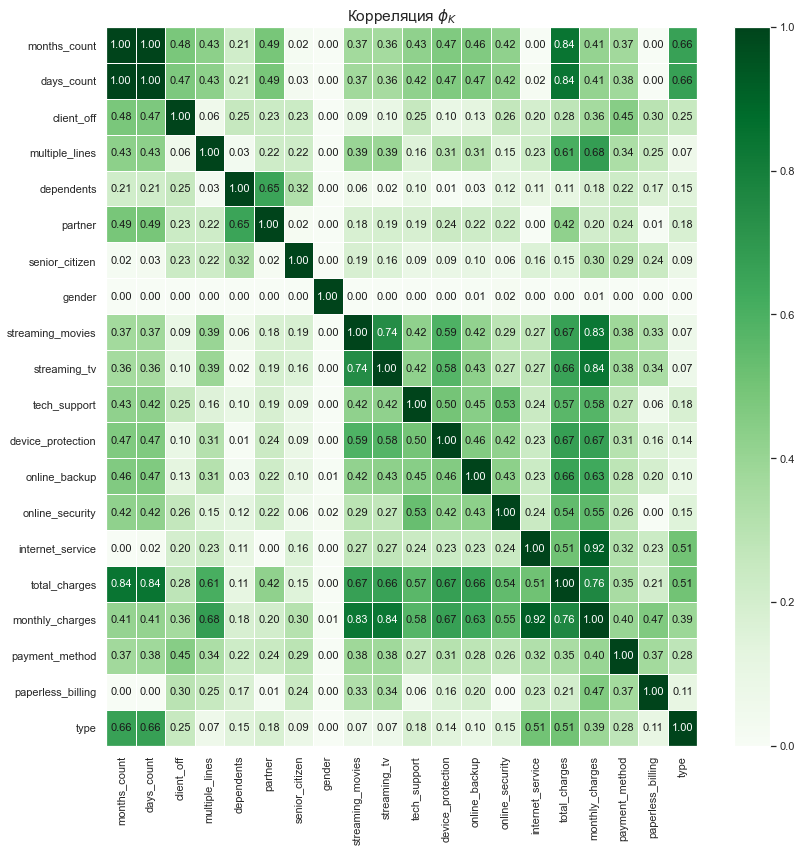

In [37]:
# φk-корреляции в графическом отображении
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.1, 
                        figsize=(12, 12))
plt.tight_layout()

> * Графики подтверждают наблюдение о том, что чёткой сегрегации в количественных признаках по классам клиентов нет.
> * Между ежемесячными платежами `monthly_charges` и общей суммой платежей `total_charges` наблюдается заметная теснота (сила) корреляционной связи. Между общей суммой платежей `total_charges` и количеством месяцев в статусе клиента `months_count` эта сила становится уже высокой. Данное обстоятельство необходимо учитывать при обучении моделей, чувствительных к мультиколлинеарности. Необходимо будет удалить некоторые из сильно коррелирующих признаков. Например, общую сумму платежей `total_charges`.
> * Самая сильная корреляция, практически равная `1`, наблюдается между двумя созданными признаками: количеством дней в статусе клиента `days_count` и количеством месяцев в нём `months_count`, что вполне логично. При обучении моделей, чуствительных к мультиколлинеарности, из этих двух признаков необходимо будет оставить один.

##### Группа категориальных признаков

Для удобства анализа категориальных признаков и сокращения дублирования кода при его многократном использовании в однотипных операциях создадим вспомогательную функцию *cat_feature_research()*.

In [38]:
# функция построения парных графиков для анализа категориальных признаков
def cat_feature_research(features:str, chart_titles:str) -> None:    
    """
    input: features (str)     - наименование исследуемого признака/признаков
           chart_titles (str) - описание исследуемого признака/признаков
    output: None
    description: Функция принимает input параметры и строит по ним столбчатый график исследуемого признака в 
                 разрезе ушёл клиент или нет
    """
    
    # подсчёт долей каждого из классов целевого признака по отношению ко всем данным
    sns.set()
    #sns.set_palette(palette='muted')
    if type(features) == tuple:
        f, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0] = sns.countplot(data=df, x=df[features[0]], hue='client_off', ax=axes[0])
        axes[0].set_title(f'\nРаспределение признака\n «{chart_titles[0]}»\n', fontsize=17)
        axes[0].set_xlabel(chart_titles[0], fontsize=14)
        axes[0].set_ylabel('Количество', fontsize=14)
        if features[0] == 'payment_method':
            axes[0].set_xticklabels([x.replace(' ', '\n') for x in list(df['payment_method'].unique())])
        axes[1] = sns.countplot(data=df, x=df[features[1]], hue='client_off', ax=axes[1])
        axes[1].set_title(f'\nРаспределение признака\n «{chart_titles[1]}»\n', fontsize=17)
        axes[1].set_xlabel(chart_titles[1], fontsize=14)
        axes[1].set_ylabel('Количество', fontsize=14)
        if features[1] == 'payment_method':
            axes[1].set_xticklabels([x.replace(' ', '\n') for x in list(df['payment_method'].unique())])
    else:
        plt.figure(figsize=(7, 5))
        ax = sns.countplot(data=df, x=df[features], hue='client_off')
        ax.set_title(f'\nРаспределение признака\n «{chart_titles}»\n', fontsize=17)
        ax.set_xlabel(chart_titles, fontsize=14)
        ax.set_ylabel('Количество', fontsize=14)
        if features[0] == 'payment_method':
            ax.set_xticklabels([x.replace(' ', '\n') for x in list(df['payment_method'].unique())])
    plt.show();
    
    return None

Получим список категориальных признаков для исследования, создадим словарь с их описаниями и построим графики распределений.

In [39]:
# получение списка категориальных признаков
cat_features = []
for feature in df.columns:
    if df[feature].dtype == 'object' or feature == 'senior_citizen':
        cat_features.append(feature)

In [40]:
# словарь описаний категориальных признаков
cat_features_dict = {
    'type': 'Тип оплаты за услуги',
    'paperless_billing': 'Электронный чек за услуги',
    'payment_method': 'Способы оплаты услуги',
    'internet_service': 'Варианты подключения интернета',
    'online_security': 'Услуга блокировки небезопасных сайтов',
    'online_backup': 'Услуга облачного хранилища',
    'device_protection': 'Наличие услуги антивируса',
    'tech_support': 'Услуга выделенной линии техподдержки',
    'streaming_tv': 'Услуга стримингового телевидения',
    'streaming_movies': 'Услуга каталога фильмов',
    'gender': 'Пол клиента',
    'senior_citizen': 'Является ли клиент пенсионером',
    'partner': 'Наличие партнёра у клиента',
    'dependents': 'Наличие детей на иждивении',
    'multiple_lines': 'Наличие мультиканальной линии'
}

Используя функцию *cat_feature_research()* построим графики распределений исследуемых категориальных признаков.

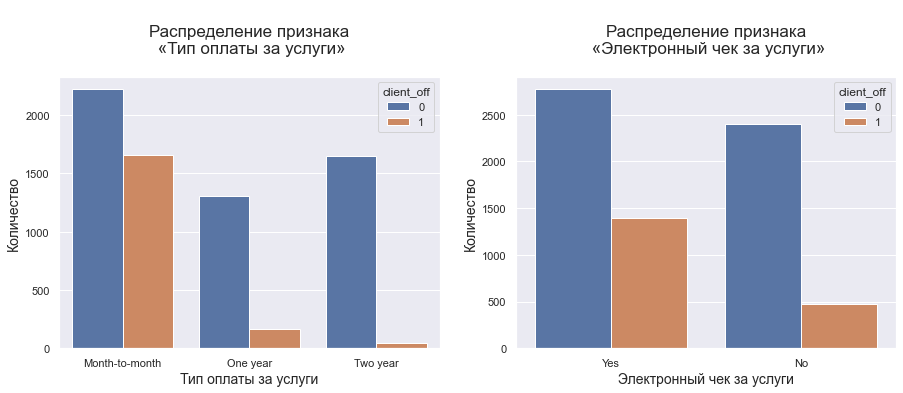

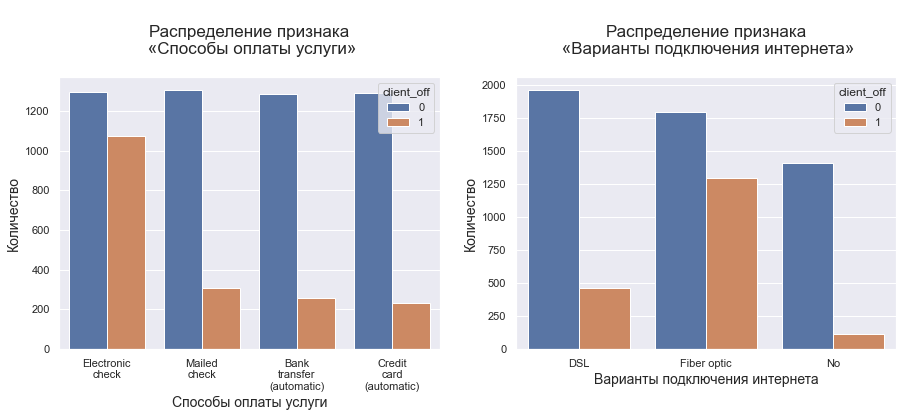

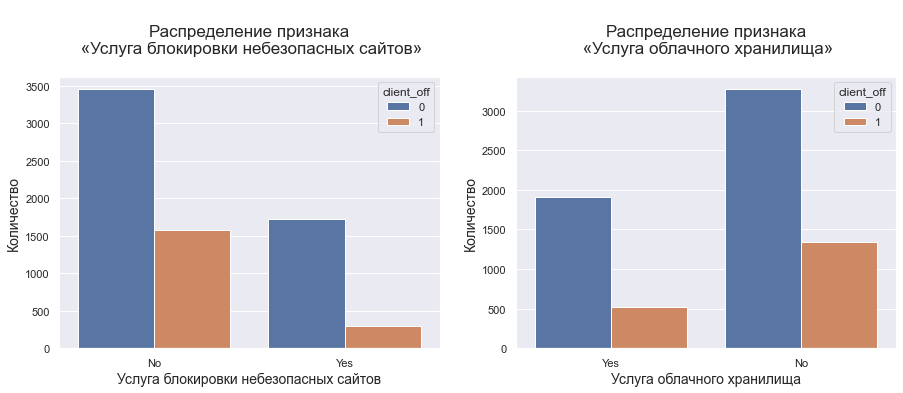

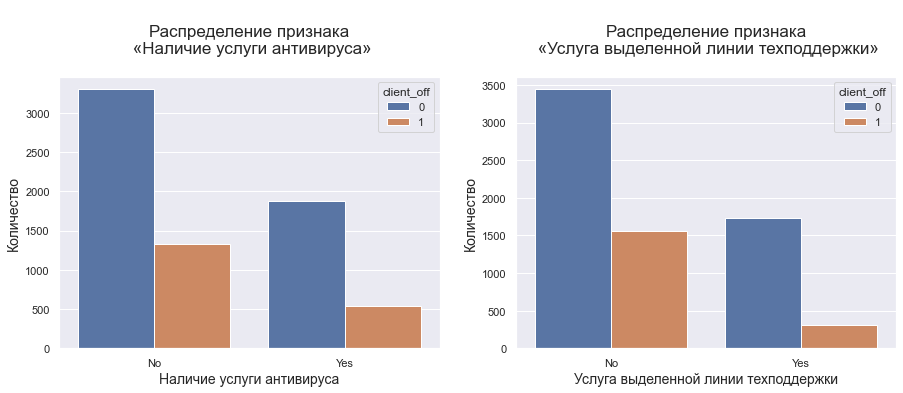

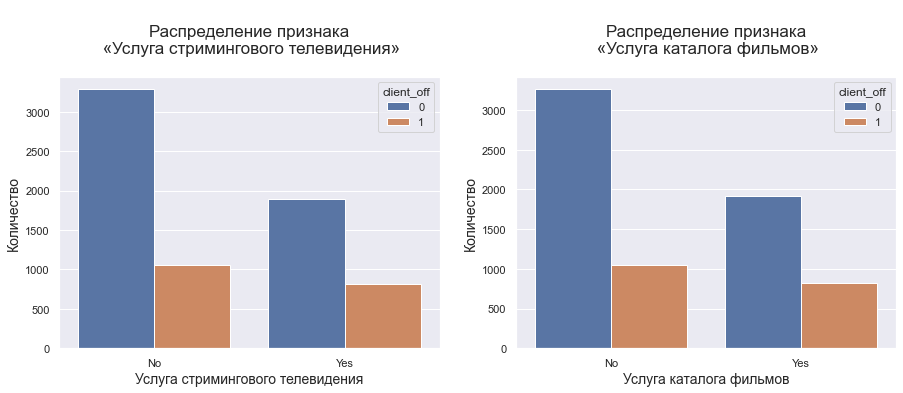

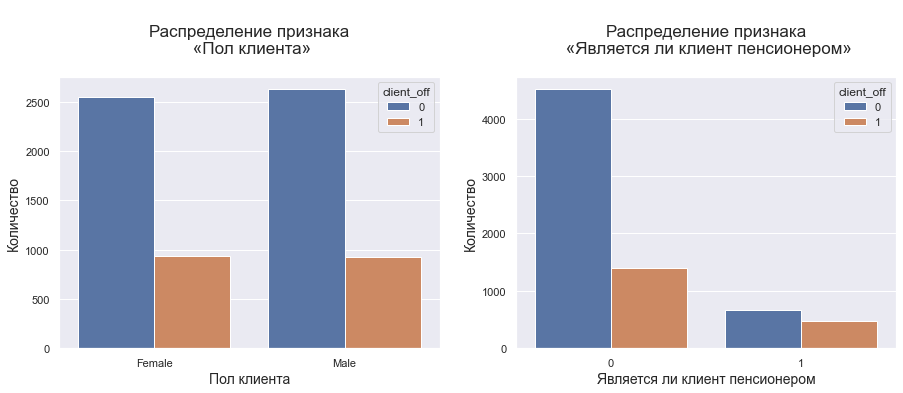

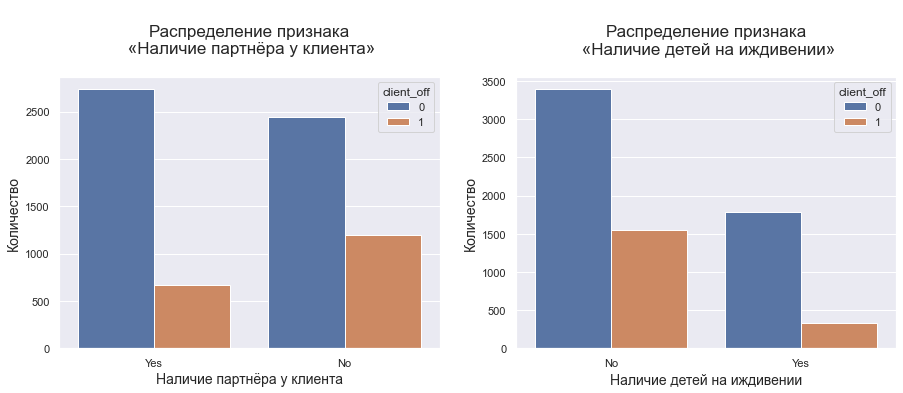

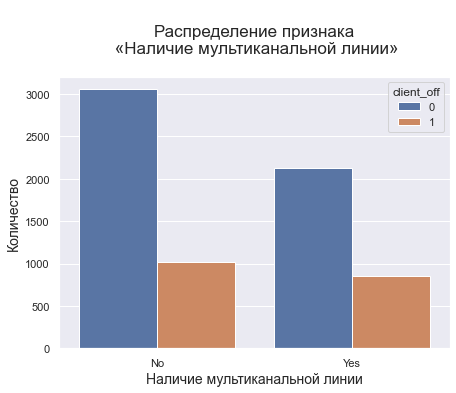

In [41]:
# построение графиков распределений категориальных признаков
for i in range(0, len(cat_features), 2):
    if i < len(cat_features)-1:
        cat_feature_research(
            ((cat_features[i], cat_features[i+1])), 
            ((cat_features_dict[cat_features[i]], cat_features_dict[cat_features[i+1]]))
        )
    else:
        cat_feature_research(cat_features[i], cat_features_dict[cat_features[i]])

> * Распределения ушедших и продолжающих оставаться пользователями компании клиентов по различным категориальным признакам неоднородно.
> * Для признака тип оплаты за услуги `type` можно отметить, что клиенты, оплачивающие услуги раз в год и тем более раз в два года гораздо менее склонны к уходу, чем те, которые оплачивают услуги помесячно. Таким образом, это может быть важным показателем лояльности клиентов.
> * Для признака электронный чек за услуги `paperless_billing` также можно отметить, что те кто получают электронные чеки уходят примерно в два раза чаще клиентов, не использующих данную услугу.
> * В способе оплаты услуги распределение не столь однозначно. Среди тех, кто пользуется электронным чеком для оплаты, соотношение ушедших и лояльных клиентов примерно одинаковое. Значительные отличия появляются при оплате почтовым чеком, автоматическим банковским переводом и автоматическим списанием с банковской карты.
> * Примерно аналогично предыдущему пункту ведёт себя распределение целевых групп клиентов в признаке варианты подключения интернета `internet_service`. Среди тех, кто использует для подключения оптоволокно, доли ушедших и лояльных клиентов примерно одинаковы. Для тех же, кто использует DSL и прочие варианты подключения наблюдается выраженный дисбаланс.
> * Группа различных атрибутов, касающихся характеристик интернет-услуг, отличается различным распределением классов ушедших и лояльных клиентов.
> * Для признака пол клиента `gender` соотношение интересующих классов одинаково для мужчин и женщин. То же самое наблюдается и для признака наличие мультиканальной линии `multiple_lines`.
> * Признак того, является ли клиент пенсионером `senior_citizen` демонстрирует то, что пенсионеры перестают быть клиентами гораздо чаще чем те, кто ими не является.
> * Также заметно влияния на распределение интересующих классов клиентов по признакам наличие партнёра у клиента `partner` и детей на иждивении `dependents`. Лояльность чаще сохраняют клиенты у которых есть партнёр и/или дети на иждивении.
> * Все рассмотренные признаки будем использовать для обучения моделей. Для этого далее они будут преобразованы к числовым значениям с помощью метода *get_dummies()* из библиотеки *sklearn*.

<h1>Примерный план дальнейшего решения задачи:</h1>

1. Создать дополнительные признаки, которые могут улучшить качество прогнозирования оттока клиентов. Такими признаками могут быть:
  * количественный признак в виде общего количества подключенных интернет-услуг у клиента;
  * категориальный (бинарный) признак нахождения в статусе клиента не менее определённого количества времени;
  * категориальный (бинарный) признак в виде общей суммы платежей менее определённого порога;
  * категориальный (бинарный) признак в виде месячной суммы платежей менее определённого порога;
  * категоризация значений ежемесячных платежей;
  * категоризация количества месяцев в статусе клиента.
  

2. Сформировать обучающий и тестовый наборы данных, выделить целевую переменную, создать функцию оценки качества моделей. В качестве метрики качества, как было уточнено в Слаке, будет выступать `ROC-AUC`, значение которой должно быть больше или равно `0.88`.


3. Получить значение метрики качества для *baseline* модели в качестве которой могут выступить модель на основе случайных предсказаний или `Dummy`-модель.


4. Обучить модели на основе логистической регрессии, случайного леса и градиентных бустингов CatBoost и LightGBM.


5. Провести сравнительный анализ моделей с целью выявления лучшей по метрике `ROC-AUC`.


6. Попробовать стекнуть две лучшие модели и посмотреть можно ли таким образом улучшить качество работы топовых моделей и если да, то насколько.


7. Построить график ROC-AUC для лучшей модели.


8. Провести анализ работы модели на основе матрицы ошибок и посмотреть можно ли улучшить качество модели за счёт варьирования порога классификации.


9. Сделать выводы.

#### Создание дополнительных признаков

На основе имеющихся признаков создадим несколько дополнительных таких как:
* `services_count` - общее количество подключенных интернет-услуг у клиента;
* `monthly_charges_group` - категории по ежемесячным платежам;
* `months_group` - категории по количеству месяцев в статусе клиента;
* `below_20_months` - признак нахождения в статусе клиента менее `20` месяцев;
* `below_65_month_payment` - величина ежемесячных платежей менее `65`;
* `below_2000_total_charges` - общая сумма платежей менее `2000`.

In [42]:
# функция для подсчёта количества подлюченных интернет-услуг
def services_count (row:pd.Series) -> int:
    """
    input: row (pandas.Series) - строка из датафрейма для которой будет вычисляться значение
    output: count (int)        - количество подключенных у клиента интернет-услуг
    description: Функция, возвращающая количество подключенных у клиента интернет-услуг
    """
    count = 0
    if row['internet_service'] == 'Yes':
        count += 1
    if row['online_security'] == 'Yes':
        count += 1
    if row['online_backup'] == 'Yes':
        count += 1
    if row['device_protection'] == 'Yes':
        count += 1
    if row['tech_support'] == 'Yes':
        count += 1
    if row['streaming_tv'] == 'Yes':
        count += 1
    if row['streaming_movies'] == 'Yes':
        count += 1
    if row['multiple_lines'] == 'Yes':
        count += 1
    return count

In [43]:
# добавление дополнительного признака в виде подлюченных интернет-услуг
df['services_count'] = df.apply(services_count, axis=1)

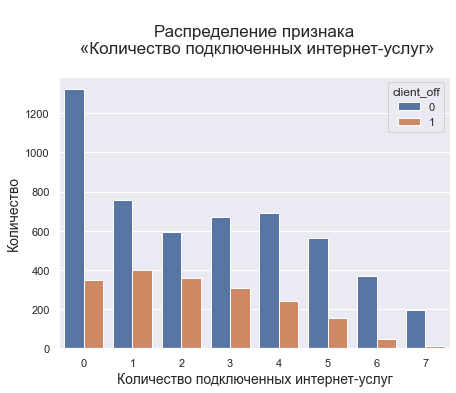

In [44]:
# построение графика распределения признака 
cat_feature_research('services_count', 'Количество подключенных интернет-услуг')

In [45]:
# функция для создания категорий по ежемесячным платежам
def group_by_charges(x:float) -> int:
    """
    input: x (float)     - значение показателя ежемесячного платежа, которому будет присвоена соотвествующая категория
    output: count (int)  - категория в виде одного из порядковых номеров в диапазоне 1-6
    description: Функция категоризации значений ежемесячных платежей
    """
    if x <= 20:
        return 1
    elif x <= 40:
        return 2
    elif x <= 60:
        return 3
    elif x <= 80:
        return 4
    elif x <= 100:
        return 5
    else:
        return 6

In [46]:
# добавление дополнительного признака в виде категорий по ежемесячным платежам
df['monthly_charges_group'] = df['monthly_charges'].apply(group_by_charges)

In [47]:
# функция для создания категорий по количеству месяцев в статусе клиента
def group_by_months(x:int) -> int:
    """
    input: x (int)       - значение показателя количество месяцев в статусе клиента компании, 
                           которому будет присвоена соотвествующая категория
    output: count (int)  - категория в виде одного из порядковых номеров в диапазоне 1-7
    description: Функция категоризации показателя количество месяцев в статусе клиента компании
    """
    if x <= 1:
        return 1
    elif x <= 10:
        return 2
    elif x <= 20:
        return 3
    elif x <= 30:
        return 4
    elif x <= 40:
        return 5
    elif x <= 60:
        return 6    
    else:
        return 7

In [48]:
# добавление дополнительного признака в виде категорий по количеству месяцев в статусе клиента
df['months_group'] = df['months_count'].apply(group_by_months)

In [49]:
# добавление признака нахождения в статусе клиента менее 20 месяцев
df['below_20_months'] = df['months_count'].apply(lambda x: 1 if x<20 else 0)

# добавление признака в виде величины ежемесячных платежей менее 65
df['below_65_month_payment'] = df['monthly_charges'].apply(lambda x: 1 if x<65 else 0)

In [50]:
# добавление признака в виде общей суммы платежей менее 2000
df['below_2000_total_charges'] = df['total_charges'].apply(lambda x: 1 if x<2000 else 0)

In [51]:
# просмотр информации о полученном после исследовательского анализа данных датафрейме 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   begin_date                7043 non-null   datetime64[ns]
 1   end_date                  7043 non-null   datetime64[ns]
 2   type                      7043 non-null   object        
 3   paperless_billing         7043 non-null   object        
 4   payment_method            7043 non-null   object        
 5   monthly_charges           7043 non-null   float64       
 6   total_charges             7043 non-null   float64       
 7   internet_service          7043 non-null   object        
 8   online_security           7043 non-null   object        
 9   online_backup             7043 non-null   object        
 10  device_protection         7043 non-null   object        
 11  tech_support              7043 non-null   object        
 12  streaming_

> * На основе имеющихся признаков созданы несколько дополнительных таких как: 
>   * `services_count` - общее количество подключенных интернет-услуг у клиента;
>   * `monthly_charges_group` - категории по ежемесячным платежам;
>   * `months_group` - категории по количеству месяцев в статусе клиента;
>   * `below_20_months` - признак нахождения в статусе клиента менее `20` месяцев;
>   * `below_65_month_payment` - величина ежемесячных платежей менее `65`;
>   * `below_2000_total_charges` - общая сумма платежей менее `2000`.
> * По результатам исследовательского анализа данных, а также их предварительной обработки, получен датафрейм, состоящий из `28` признаков и `7043` объектов, который будет использован далее для обучения моделей для решения задачи классификации.

### Выводы по анализу данных

> * Данные успешно загружены из полученных файлов `contract.csv`, `internet.csv`, `personal.csv` и `phone.csv`.
> * Для удобства работы и последующего анализа данных все таблицы из четырёх файлов объединены в общий датафрейм по индексам `customerID`.
> * Нарушения змеиного стиля в названиях столбцов в полученной сводной таблице устранены преобразованием названий атрибутов из `CamelCase` в `snake_case`.
> * Установлено, что данные телекоммуникационной компании о клиентах представлены за период `6` лет и `3` месяца - с `октября 2013` года по `февраль 2020`.
> * Отток клиентов зафиксирован в последние четыре месяца и происходил по первым числам каждого месяца. Таким образом, дата расторжения договора представлена четырьмя уникальными датами с равномерным распределением количества ушедших клиентов между ними, что ставит вопрос о корректности данных и необходимости её уточнения.
> * На основании данных о дате расторжения контракта сформирован целевой признак бинарного типа `client_off`, представленный двумя метками: `0` - клиент не ушёл, `1` - клиент расторг договор.
> * Созданы два дополнительных признака в виде `days_count` - общего количества дней, в течение которых клиент пользуется/пользовался услугами оператора и `months_count`- общего количества месяцев, в течение которых клиент являлся или продолжает являться пользователем услуг.
> * Проведена оценка распределения значений признаков, которая позволила установить следующее:
>     * целевой признак `client_off` имеет дисбаланс классов среди ушедших и продолжающих пользоваться услугами клиентов с соотношением `26.5%` и `73.5%` соотвественно, поэтому при обучении моделей, которые поддерживают взвешивание классов в расчётах, будем использовать параметр `class_weight` со значением `'balanced'`;
>     * изучены распределения количественных признаков таких как `days_count` - количество дней в статусе клиента, `months_count` - количество месяцев в статусе клиента, `monthly_charges` - ежемесячные платежи, `total_charges` - общая сумма платежей в результате чего установлено, что несмотря на значимые отличия в средних и медианных значениях для исследуемых групп ушедших и продолжающих оставаться лояльными клиентов, чёткого разделения в рассмотренных распределениях не наблюдается;
>     * установлена очень сильная корреляция в `0.999` между `days_count` - общим количеством дней в статусе клиента `months_count`- общим количеством месяцев, а также сильная корреляция со значением `0.825` между ежемесячными платежами `monthly_charges` и общей суммой платежей `total_charges`, что необходимо учитывать при обучении моделей, чувствительных к мультиколлинеарности признаков;
>     * также проведён анализ распределений группы категориальных признаков по результатам которого установлено, что распределение ушедших и продолжающих оставаться пользователями компании клиентов по отдельным признакам неоднородно и присутствуют признаки с выраженными различиями, такие как `type` - тип оплаты за услуги или `paperless_billing` - получение клиентов электронного чека за услуги вместо бумажного, так и признаки в которых эти различия отсуствуют, такие как `gender` - пол клиента или незначительны, как в случае признака `partner` в виде наличия у клиента партнёра.
> * В сводную таблицу признаков добавлена группа дополнительных атрибутов, которые сформированы из уже имеющихся, таких как:
>     * `services_count` - общее количество подключенных интернет-услуг у клиента;
>     * `monthly_charges_group` - категории по ежемесячным платежам;
>     * `months_group` - категории по количеству месяцев в статусе клиента;
>     * `below_20_months` - признак нахождения в статусе клиента менее `20` месяцев;
>     * `below_65_month_payment` - величина ежемесячных платежей менее `65`;
>     * `below_2000_total_charges` - общая сумма платежей менее `2000`.
> * По результатам исследовательского анализа данных, а также их предварительной обработки получен датафрейм, состоящий из `28` признаков и `7043` объектов.

## Обучение моделей

### Формирование обучающего и тестового наборов данных

Проведём обучение и последующий анализ нескольких моделей предварительно подготовив данные для обучения. Для этого исключим из данных два атрибута:
* `begin_date` - дату заключения договоров, так как информация, которую он представляет перенесена в созданный на его основе атрибут `days_count` количество дней, прошедших со дня заключения контракта;
* `end_date` - атрибут на основании которого сформирован целевой признак.

In [52]:
# удаление столбцов begin_date и end_date
df_final = df.drop(['begin_date', 'end_date'], axis=1).reset_index(drop=True)
df_final.head(5)

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,...,multiple_lines,client_off,days_count,months_count,services_count,monthly_charges_group,months_group,below_20_months,below_65_month_payment,below_2000_total_charges
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,...,No,0,31,1,1,2,1,1,1,1
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,...,No,0,1036,34,2,3,5,0,1,1
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,...,No,1,61,2,2,3,2,1,1,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,...,No,0,1371,45,3,3,6,0,1,1
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,...,No,1,61,2,0,4,2,1,0,1


Разделим данные на две части: обучающую и тестовую выборки в пропорции 3:1, используя функцию `train_test_split` из библиотеки `sklearn.model_selection`.

In [53]:
# разделение данных на обучающую и тестовую выборки с заданным соотношением
df_train, df_test = train_test_split(df_final, test_size=0.25, random_state=RND)

Проверим размеры полученных выборок и соотношение классов целевой переменной в них.

In [54]:
# проверка размеров полученных частей
df_train.shape, df_test.shape

((5282, 26), (1761, 26))

In [55]:
# проверка соотношения классов целевой переменной в тренировочном наборе данных
df_train['client_off'].value_counts() / df_train['client_off'].shape[0]

0    0.736085
1    0.263915
Name: client_off, dtype: float64

In [56]:
# проверка соотношения классов целевой переменной в тестовом наборе данных
df_test['client_off'].value_counts() / df_test['client_off'].shape[0]

0    0.730267
1    0.269733
Name: client_off, dtype: float64

После разделения данных на обучающую и тестовую выборки в них сохранился характерный для исходных данных дисбаланс классов, заключающийся в том, что доли ушедних и лояльных клиентов составляют `≈27%` и `≈73%` соотвественно.

Также выделим целевую переменную из полученных выборок.

In [57]:
# выделение целевой переменной из обучающей и тестовой выборок
X_train = df_train.drop(['client_off'], axis=1)
y_train = df_train['client_off']
x_test = df_test.drop(['client_off'], axis=1)
y_test = df_test['client_off']

Создадим вспомогательные функции для вывода значений метрики по результатам обучения *print_scores_on_train()* и проверки моделей на тестовой выборке *print_scores_on_test()*.

In [58]:
# функция для печати лучшего значения метрики ROC-AUC на обучении и сводной информации о параметрах модели
def print_scores_on_train(clf:Union[GridSearchCV, CatBoostClassifier], 
                          X_train:pd.DataFrame, 
                          y_train:pd.DataFrame, 
                          params:dict, model_name:str) -> float:
    """
    input:        clf (sklearn.model)         - лучшая модель по результатам работы GridSearchCV
                  X_train (pandas.DataFrame)  - обучающий набор данных
                  y_train (pandas.DataFrame)  - таргеты для обучающего набора данных
                  params (dict)               - лучшие параметры
                  model_name (str)            - название используемой модели
                  ret (bool)                  - флаг необходимости возврата функцией лучшей модели
    output:       roc_score (float)           - значение метрики ROC-AUC лучшей модели
                  f1 (float)                  - значение метрики F1 лучшей модели
                  accuracy (float)            - значение метрики Accuracy лучшей модели
                  fit_time (float)            - время обучения модели, секунд
    description:  Функция выводит на печать значение метрики ROC-AUC и параметры лучшей модели по результатам подобора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    if model_name != 'CatBoostClassifier':
        roc_score = clf.best_score_
    else:
        roc_score = pd.Series(clf['cv_results']['test-AUC-mean']).max()
    
        
    print_tab_row(
        'Лучшее значение ROC-AUC для модели ' + model_name + ':',
        roc_score,
        total_width=85,
        col_1_format='| {: <70}|',
        col_2_format='{: >10.5f} |',
    )
          
    print ('| {: <70}|'.format('Лучшие параметры:'), end='')
    print(' ' * 11 + '|')
    
    if model_name != 'CatBoostClassifier':
        best_parameters = clf.best_estimator_.get_params()
        
        for param_name in sorted(params.keys()):
            print('|\t{: <64}|'.format(param_name), end='')
            print('{: >10} |'.format(str(best_parameters[param_name])))
        print('-' * 85)
    else:
        for param in sorted(params.keys()):
            print('|\t{: <64}|'.format(param), end='')
            print('{: >10} |'.format(str(grid_search_cb['params'][param])))
        print('-' * 85)
        
    return roc_score

In [59]:
# функция для печати значения метрики ROC-AUC на тестовых данных
def print_scores_on_test(clf:Union[GridSearchCV, CatBoostClassifier], 
                         x_test:pd.DataFrame, 
                         y_test:pd.DataFrame, 
                         params:dict, model_name:str) -> float:
    """
    input:        model                       - модель классификации
                  clf (sklearn.model)         - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  x_test (pandas.DataFrame)   - тестовый набор данных
                  y_test (pandas.DataFrame)   - таргеты из тестового набора данных
                  model_name (str)            - название используемой модели
    output:       roc_score (float)          - значение метрики ROC_AUC на тестовых данных
    description:  Функция выводит на печать значение ROC-AUC и параметры лучшей модели по результатам подбора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print('-' * 85)
    print ('| {: <70}|'.format('Параметры модели:'), end='')
    print(' ' * 11 + '|')
    
    if model_name != 'CatBoostClassifier':
        best_parameters = clf.best_estimator_.get_params()
        
        for param_name in sorted(params.keys()):
            print('|\t{: <64}|'.format(param_name), end='')
            print('{: >10} |'.format(str(best_parameters[param_name])))
            
        predict_proba = clf.best_estimator_.predict_proba(x_test)[:, 1]
        roc_score = roc_auc(y_test, predict_proba)
        
        preds = clf.best_estimator_.predict(x_test)
        f1 = f1_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
    else:
        for param in sorted(params.keys()):
            print('|\t{: <64}|'.format(param), end='')
            print('{: >10} |'.format(str(grid_search_cb['params'][param])))
        
        predict_proba = clf.predict_proba(x_test)[:, 1]
        roc_score = roc_auc(y_test, predict_proba)
        
        preds = clf.predict(x_test)
        f1 = f1_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        
    print_tab_row(
        'ROC-AUC на тестовых данных для ' + model_name + ':',
        roc_score,
        total_width=85,
        col_1_format='| {: <70}|',
        col_2_format='{: >10.5f} |',
        b_line=False
    )
        
    print_tab_row(
        'Значение F1-меры:',
        f1,
        total_width=85,
        col_1_format='| {: <70}|',
        col_2_format='{: >10.5f} |',
        b_line=False
    )
        
    print_tab_row(
        'Значение Accuracy:',
        accuracy,
        total_width=85,
        col_1_format='| {: <70}|',
        col_2_format='{: >10.5f} |'
    )

    return roc_score

Зададим функцию для расчёта контрольной метрики (*ROC-AUC*).

In [60]:
# функция расчета метрики ROC-AUC
def roc_auc(y_true, y_predicted) -> float:
    return roc_auc_score(y_true, y_predicted)  

In [61]:
# создание параметра для контроля метрики ROC-AUC при кросс-валидации
scoring = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

### Обучение различных моделей

Обучим различные модели и сравним их результаты по *ROC-AUC* метрике, чтобы попытаться достичь результата `≥ 0.88` как того требуют условия задания.

Для этого будут обучены две константных модели, лучшая из которых будет использована в качестве *baseline*-модели с результатами которой будут далее сравниваться результаты остальных моделей. В качестве константных моделей будут использованы:
* `случайная модель`;
* `dummy-модель`.

*Baseline*-модель сравним по *ROC-AUC* метрике с результатами следующих моделей после подбора гиперпараметров с кросс-валидацией:
* `логистическая регрессия`;
* `случайный лес`;
* `CatBoostClassifier`;
* `LGBMClassifier`.

#### Случайная модель

Получим значение *ROC-AUC* метрики от случайных значений целевой переменной. Для этого выполним `10000` псевдослучайных рандомных «предсказаний» классов виде значений верояностей в диапазоне от `0` до `1` и выберем из них то, которое обеспечит максимальное значение *ROC-AUC* метрики.

In [62]:
# получение значений точности для случайно сгенерированных значений целевого признака
start_time = datetime.datetime.now()

roc = []
best_rnd_roc = 0

for i in range(10000):
    np.random.seed(i)
    predict_proba = np.random.rand(y_train.shape[0], 2)[:, 1]
    roc_rnd_result = roc_auc(y_train, predict_proba)
    roc.append(roc_rnd_result)
    
    if roc_rnd_result > best_rnd_roc:
        best_rnd_roc = roc_rnd_result
        preds = (predict_proba > 0.5).astype('int64')
        f1_rnd = f1_score(y_train, preds)
        accuracy_rnd = accuracy_score(y_train, preds)

print_tab_row(
    'ROC-AUC для случайно сгенерированных значений классов:', 
    best_rnd_roc,
    total_width=85,
    col_1_format='| {: <70}|',
    col_2_format='{: >10.5f} |'
)

learning_time_rm = (datetime.datetime.now()-start_time).seconds

-------------------------------------------------------------------------------------
| ROC-AUC для случайно сгенерированных значений классов:                |   0.53752 |
-------------------------------------------------------------------------------------


Создадим функцию для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха для сгенерированных ответов.

In [63]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def random_data_research(data:pd.Series, feature:str, chart_title:str, x_lims=(0, 100), main_df=True) -> None:    
    """
    input: data (pandas.Series) - данные для построения гистограммы и диаграммы размаха
           feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           x_lims (tuple)       - диапазон значений по оси X
    output: None
    description: Функция принимает input параметры, выводит таблицу с описательными статистиками, строит диаграмму 
                 размаха и графики распределение частот для исследуемого признака
    """
    display(data.describe())

    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw=dict(height_ratios=[1, 4]))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(f'\nГрафик распределения признака «{feature}» \n {chart_title}\n', fontsize=17)
    axes[0] = sns.boxplot(data=data, orient='h', ax=axes[0], palette='BuPu')
    axes[0].set_xlim(x_lims)
    axes[0].set_xticklabels([])

    axes[1] = sns.histplot(
        data=data,
        alpha=0.45,
        ax=axes[1],
        kde=True,
        stat='frequency',
        bins=100
    )
    axes[1].set_ylabel('Частота встречаемости', fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();
    
    return None

count    10000.000000
mean         0.500032
std          0.008979
min          0.467326
25%          0.493917
50%          0.500011
75%          0.505995
max          0.537517
Name: roc, dtype: float64

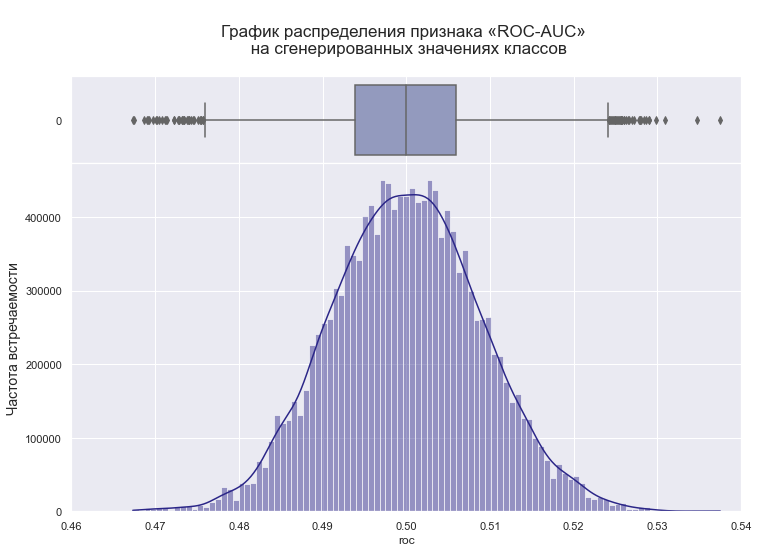

In [64]:
# оценка распределения метрики ROC-AUC для сгенерированных значений целевого признака
random_data_research(
    pd.DataFrame(roc).rename(columns={0:'roc'})['roc'],
    'ROC-AUC',
    'на сгенерированных значениях классов',
    x_lims=(0.46, 0.54),
    main_df=False
)

> * Для модели на основе случайно сгенерированных ответов в количестве, равном длине тестовой выборки, в результате проведения `10000` итераций получено лучшее значение метрики *ROC-AUC*, равное `0.537`.
> * Форма распределения полученных значений *ROC-AUC* метрики практически идеально симметрична, точно соотвествует форме Гауссовского распределения со средним и медианным значениями, равными `0.5`, что подтверждает случайность полученных значений.

#### Dummy-модель

Также получим оценку по метрике *ROC-AUC* для dummy-модели, выполняющей «предсказания» по стратегии `stratified`, когда прогнозы генерируются с учётом распределения классов обучающей выборки.

In [65]:
# создание модели на основе DummyClassifier
model_dm = DummyClassifier(strategy='stratified', random_state=RND)

In [66]:
# «обучение» модели на основе DummyClassifier
start_time = datetime.datetime.now()

model_dm.fit(X_train, y_train)

learning_time_dm = (datetime.datetime.now()-start_time).seconds

In [67]:
# получение предсказаний от DummyClassifier и получение метрики ROC-AUC для неё
predicted_classes = model_dm.predict_proba(X_train)[:, 1]

roc_score_dm = roc_auc(y_train, predicted_classes)

preds = model_dm.predict(X_train)
f1_dm = f1_score(y_train, preds)
accuracy_dm = accuracy_score(y_train, preds)

In [68]:
# значение метрик ROC-AUC, F1 и Accuracy для DummyClassifier
print_tab_row(
    'Значение ROC-AUC для DummyClassifier:', 
    roc_score_dm,
    total_width=85,
    col_1_format='| {: <70}|',
    col_2_format='{: >10.5f} |'
)

-------------------------------------------------------------------------------------
| Значение ROC-AUC для DummyClassifier:                                 |   0.50328 |
-------------------------------------------------------------------------------------


> * Для модели на основе классификатора *DummyClassifier* получено значение метрики *ROC-AUC*, равное `0.504`, что хуже результата случайной модели.
> * Поэтому, случайная модель и её *ROC-AUC* метрика, равная `0.537`, будут использованы в качестве *baseline* модели с которой будут сравниваться результаты всех последующих обученных моделей.

#### Логистическая регрессия

Обучим модель логистической регрессии *LogisticRegression* и сравним полученное после подбора гиперпараметров на обучающей выборке значение метрики *ROC-AUC* с базовой моделью на случайных предсказаниях.

Перед обучением логистической регрессии удалим из обучающего набора данных признаки `total_charges` и `months_count`, чтобы избавиться от мультиколлинеарности.

В подборе гиперпараметров модели будут участовать коэффициент регуляризации `C` и факт использование свободного члена `fit_intercept`.

In [69]:
# удаление признаков total_charges и months_count для избавление от мультиколлинеарности в данных
X_train_lr = X_train.drop(['total_charges', 'months_count'], axis=1)
x_test_lr = x_test.drop(['total_charges', 'months_count'], axis=1)

In [70]:
# создание моделей на основе логистической регрессии с заданными для перебора диапазонами гиперпараметров 
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, random_state=RND)

params_lr = {
    'model__C': [0.5, 1, 5],
    'model__fit_intercept': [True, False]
}

Создадаим *pipline* для масштабирования признаков для обучения линейной модели с помощью функций кодирования категориальных признаков техникой *One-Hot Encoding* через `OneHotEncoder` и стандартизации данных через `StandardScaler`.

In [71]:
# pipline для обработки данных для обучения линейных моделей
numeric_features = X_train_lr.select_dtypes('number').columns
categor_features = X_train_lr.select_dtypes('object').columns

# pipline для препроцессинга обучающих данных для линейных моделей
transform_steps_lm = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',
            transformers=[  
                ('ohe', OneHotEncoder(drop='first'), categor_features),
                ('std', StandardScaler(copy=False, with_mean=False, with_std=False), numeric_features)
            ])
    ),
]

In [72]:
# определение поиска по заданным значениям гиперпараметров для логистической регрессии
grid_search_lr = GridSearchCV(
    Pipeline(transform_steps_lm + [('model', model_lr)]), 
    param_grid=params_lr, 
    cv=CV_FOLDS, 
    scoring=scoring
) 

In [73]:
%%time
# обучение модели на основе логистической регрессии
grid_search_lr.fit(X_train_lr, y_train)

CPU times: total: 17.5 s
Wall time: 4.73 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('qtl',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['type', 'paperless_billing', 'payment_method', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'gender', 'partner', 'dependents',
       'mu...
       'monthly_charges_group', 'months_group', 'below_20_months',
       'below_65_month_payment', 'below_2000_total_charges'],
      dtype='object'))])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           n_jobs=-1,
                                                           random_state=290822))]),
             param_grid={'model__C': [0.5, 1, 5],
                         'model__fit_intercept': [True, False]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True))

In [74]:
# получение результатов работы лучшей модели на основе логистической регрессии после подбора гиперпараметров
score_lr = print_scores_on_train(
    grid_search_lr, 
    X_train_lr, 
    y_train, 
    params_lr, 
    'логистической регрессии'
)

-------------------------------------------------------------------------------------
| Лучшее значение ROC-AUC для модели логистической регрессии:           |   0.84865 |
-------------------------------------------------------------------------------------
| Лучшие параметры:                                                     |           |
|	model__C                                                        |       0.5 |
|	model__fit_intercept                                            |      True |
-------------------------------------------------------------------------------------


> * Для модели на основе логистической регрессии на обучающей выборке после подбора гиперпараметров получено значение метрики *ROC-AUC*, равное `0.848`, что существенно выше аналогичного показателя случайной модели, равного `0.537`.
> * Полученного значения недостаточно для выполнения условия задания *ROC-AUC* `≥ 0.88`. Попробуем обучить другие типы моделей.

#### Случайный лес

Рассмотрим модель случайного леса. В подборе гиперпараметров данной модели будут участвовать глубина дерева `max_depth` и количество деревьев `n_estimators`.

In [75]:
# создание модели на основе случайного леса с заданным набором параметров
model_rf = RandomForestClassifier(class_weight='balanced', random_state=RND, n_jobs=-1)

params_rf = {
    'model__n_estimators': [110, 115, 120],
    'model__max_depth': [7, 8, 9]
}

In [76]:
# pipline для обработки данных для случайного леса
numeric_features = X_train.select_dtypes('number').columns
categor_features = X_train.select_dtypes('object').columns

# pipline для препроцессинга обучающих данных для случайного леса
transform_steps_rf = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',
            transformers=[  
                ('oen', OrdinalEncoder(), categor_features)
            ])
    ),
]

In [77]:
#  определение поиска по заданным значениям гиперпараметров для случайного леса
grid_search_rf = GridSearchCV(
    Pipeline(transform_steps_rf + [('model', model_rf)]), 
    param_grid=params_rf, 
    cv=CV_FOLDS, 
    scoring=scoring,
    )

In [78]:
%%time
# обучение моделей на основе случайного леса
grid_search_rf.fit(X_train, y_train)

CPU times: total: 5.89 s
Wall time: 4.98 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('qtl',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oen',
                                                                         OrdinalEncoder(),
                                                                         Index(['type', 'paperless_billing', 'payment_method', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'gender', 'partner', 'dependents',
       'multiple_lines'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=290822))]),
             param_grid={'model__max_depth': [7, 8, 9],
                         'model__n_estimators': [110, 115, 120]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True))

In [79]:
# получение результатов работы лучшей модели на основе случайного леса на обучающей выборке
score_rf = print_scores_on_train(
    grid_search_rf, 
    X_train_lr, 
    y_train, 
    params_rf, 
    'случайного леса'
)

-------------------------------------------------------------------------------------
| Лучшее значение ROC-AUC для модели случайного леса:                   |   0.86261 |
-------------------------------------------------------------------------------------
| Лучшие параметры:                                                     |           |
|	model__max_depth                                                |         8 |
|	model__n_estimators                                             |       120 |
-------------------------------------------------------------------------------------


> * Для модели на основе случайного леса на обучающей выборке после подбора гиперпараметров получено значение метрики *ROC-AUC*, равное `0.863`, что значимо выше аналогичного показателя модели на основе линейной регрессии, равного `0.849`.
> * Модель на основе случайного леса гарантированно выполняет условие задания `≥ 0.88`. Обучим другие модели и посмотрим можно ли улучшить данный результат.

#### CatBoostClassifier

Перейдём к моделям градиентного бустинга, обучим модель и получим значение инетересующей метрики на основе алгоритма *CatBoostClassifier*.

Библиотека *CatBoost* умеет работать с категориальными признаками в виде строк. Поэтому, пересоздадим обучающий и тестовый наборы данных, чтобы получить категориальные признаки в исходном виде, которые ранее были закодированы в числовые техникой *OHE*.

In [80]:
# удаление столбцов begin_date и end_date
df_final = df.drop(['begin_date', 'end_date'], axis=1).reset_index(drop=True)
df_final.head(5)

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,...,multiple_lines,client_off,days_count,months_count,services_count,monthly_charges_group,months_group,below_20_months,below_65_month_payment,below_2000_total_charges
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,...,No,0,31,1,1,2,1,1,1,1
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,...,No,0,1036,34,2,3,5,0,1,1
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,...,No,1,61,2,2,3,2,1,1,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,...,No,0,1371,45,3,3,6,0,1,1
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,...,No,1,61,2,0,4,2,1,0,1


Так как модели на основе *CatBoostClassifier* необходимо явно указывать какие признаки являются категориальными, создадим соотвествующий список категориальных переменных. 

In [81]:
# создание списка категориальных переменных
num_features = ['monthly_charges', 'total_charges', 'months_count']

target = 'client_off'

cat_features = [c for c in df_final.columns if c not in num_features + [target]]

Снова разделим данные на две части: обучающую и тестовую выбороки в пропорциях 3:1.

In [82]:
# разделение данных на обучающую и тестовую выборки с заданным соотношением
df_train, df_test = train_test_split(df_final, test_size=0.25, random_state=RND)

In [83]:
# проверка соотношения классов целевой переменной в тренировочном наборе данных
df_train['client_off'].value_counts() / df_train['client_off'].shape[0]

0    0.736085
1    0.263915
Name: client_off, dtype: float64

In [84]:
# проверка соотношения классов целевой переменной в тестовом наборе данных
df_test['client_off'].value_counts() / df_test['client_off'].shape[0]

0    0.730267
1    0.269733
Name: client_off, dtype: float64

И также выделим целевую переменную из полученных выборок.

In [85]:
# выделение целевой переменной из обучающей и тестовой выборок
X_train = df_train.drop(['client_off'], axis=1)
y_train = df_train['client_off']
x_test = df_test.drop(['client_off'], axis=1)
y_test = df_test['client_off']

Cоздадим модель на основе *CatBoostClassifier*. В качестве настраиваемых гиперпараметров модели будем использовать параметр скорости обучения `learning_rate` и глубину деревьев `depth`.

In [86]:
# создание модели на основе CatBoostClassifier с заданным набором параметров
model_cb = CatBoostClassifier(
    cat_features=cat_features,
    verbose=500,
    eval_metric='AUC:hints=skip_train~false',
    task_type='CPU',
    iterations=2000,
    thread_count=-1,
    random_state=RND,
    early_stopping_rounds=250
)

params_cb = {
    'learning_rate': [0.002, 0.02, 0.2],
    'depth': [3, 4, 5]
}

In [87]:
%%time
# обучение моделей на основе CatBoostClassifier и получение лучшего результата на обучении
grid_search_cb = model_cb.grid_search(
    params_cb,
    cv=CV_FOLDS,
    X=X_train, 
    y=y_train,
    partition_random_seed=RND,
    stratified=True,
    plot=False
)

0:	learn: 0.9005886	test: 0.9055516	best: 0.9055516 (0)	total: 163ms	remaining: 5m 26s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9502797136
bestIteration = 65

0:	loss: 0.9502797	best: 0.9502797 (0)	total: 5.27s	remaining: 42.2s
0:	learn: 0.9005886	test: 0.9055516	best: 0.9055516 (0)	total: 10.7ms	remaining: 21.5s
500:	learn: 0.9548601	test: 0.9562177	best: 0.9562224 (495)	total: 9.37s	remaining: 28s
1000:	learn: 0.9600020	test: 0.9564002	best: 0.9566325 (904)	total: 19.2s	remaining: 19.2s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9566325321
bestIteration = 904

1:	loss: 0.9566325	best: 0.9566325 (1)	total: 27.7s	remaining: 1m 36s
0:	learn: 0.9005886	test: 0.9055516	best: 0.9055516 (0)	total: 17.7ms	remaining: 35.3s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9565566776
bestIteration = 144

2:	loss: 0.9565567	best: 0.9566325 (1)	total: 36s	remaining: 1m 11s
0:	learn: 0.9025749	test: 0.9055516	best: 0.9055516

In [88]:
# получение результатов работы лучшей модели на основе CatBoostClassifier после подбора гиперпараметров
score_cb = print_scores_on_train(
    grid_search_cb, 
    X_train, 
    y_train, 
    params_cb, 
    'CatBoostClassifier'
)

-------------------------------------------------------------------------------------
| Лучшее значение ROC-AUC для модели CatBoostClassifier:                |   0.95594 |
-------------------------------------------------------------------------------------
| Лучшие параметры:                                                     |           |
|	depth                                                           |         4 |
|	learning_rate                                                   |      0.02 |
-------------------------------------------------------------------------------------


Так как подбор гиперпараметров на кросс-валидации проводился с ранним остановом, то определим количество итераций, соотвествующих лучшей модели.

In [89]:
# определние количества итераций, соотвествующих лучшей модели
best_iter = pd.Series(grid_search_cb['cv_results']['iterations']).max()

print_tab_row(
    'Количество итераций, соотвествующих лучшей модели CatBoostClassifier:', 
    best_iter,
    total_width=85,
    col_1_format='| {: <70}|',
    col_2_format='     {: >d} |'
)

-------------------------------------------------------------------------------------
| Количество итераций, соотвествующих лучшей модели CatBoostClassifier: |     1456 |
-------------------------------------------------------------------------------------


Посмотрим на то, какие признаки с точки зрения модели на основе градиентного бустинга *CatBoostClassifier* оказались наиболее значимыми.

In [90]:
# просмотр значимости признаков для модели на основе градиентного бустинга CatBoostClassifier
features_importance = pd.DataFrame(
    model_cb.get_feature_importance(),
    index=X_train.dtypes.index,
    columns=['features_importance']
).sort_values(by='features_importance', ascending = False)

features_importance.iloc[:16, :].style.bar()

,features_importance
days_count,49.423812
internet_service,8.315344
type,7.962158
months_group,6.471535
monthly_charges,4.313117
total_charges,4.133580
payment_method,3.378698
monthly_charges_group,2.513787
months_count,2.399428
services_count,2.005824


> * Для модели на основе *CatBoostClassifier* на обучающей выборке после подбора гиперпараметров получено значение метрики *ROC-AUC*, равное `0.956`. Таким образом, на данном этапе данная модель обеспечила лучший результат по контрольной метрике.
> * Тремя наиболее значимыми признаками по результатам обучения модели на основе *CatBoostClassifier* стали `days_count` - количество дней в статусе клиента компании с даты заключения договора, `internet_service` - варианты подключения интернет-соединения и `type` - тип оплаты за услуги.

#### LGBMClassifier

С категориальными признаками также способна работать библиотека *LightGBM*. Эта ещё одна отличная библиотека градиентного бустинга, которая обеспечиваею хорошую точность и скорость расчётов.

Произведём подбор гиперпараметров и получим значение метрики *ROC-AUC* для модели на основе *LGBMClassifier*. Категориальные признаки в библиотеке *LightGBM* должны иметь тип `category`, поэтому произведём требуемые преобразования.

In [91]:
# изменение типа данных категориальных переменных с object на category
for column in cat_features:
    X_train[column] = X_train[column].astype('category')
    x_test[column] = x_test[column].astype('category')

В качестве настраиваемых гиперпараметров модели будем также использовать параметр скорости обучения `learning_rate` и глубину деревьев `max_depth`.

In [92]:
# создание модели с необходимыми настройками гиперпараметров
model_lgb = LGBMClassifier(
    n_estimators=100, 
    n_jobs=-1, 
    objective='binary', 
    random_state=RND,
    min_split_gain=0.75,
    min_child_samples=28,
    class_weight='balanced'
)

params_lgb = {
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.0225, 0.025, 0.275]
}

In [93]:
# определение поиска по заданным значениям гиперпараметров для LGBMClassifier
grid_search_lgb = GridSearchCV(
    Pipeline([('model', model_lgb)]), 
    param_grid=params_lgb, 
    cv=CV_FOLDS, 
    scoring=scoring
)

In [94]:
%%time
# обучение моделей на основе LGBMClassifier с подбором гиперпараметров
grid_search_lgb.fit(X_train, y_train)

CPU times: total: 29.3 s
Wall time: 2.56 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LGBMClassifier(class_weight='balanced',
                                                       min_child_samples=28,
                                                       min_split_gain=0.75,
                                                       objective='binary',
                                                       random_state=290822))]),
             param_grid={'model__learning_rate': [0.0225, 0.025, 0.275],
                         'model__max_depth': [3, 4, 5, 6]},
             scoring=make_scorer(roc_auc_score, needs_threshold=True))

In [95]:
# получение результатов работы лучшей модели на основе LGBMClassifier на обучающей выборке
score_lg = print_scores_on_train(
    grid_search_lgb, 
    X_train, 
    y_train, 
    params_lgb, 
    'LGBMClassifier'
)

-------------------------------------------------------------------------------------
| Лучшее значение ROC-AUC для модели LGBMClassifier:                    |   0.95540 |
-------------------------------------------------------------------------------------
| Лучшие параметры:                                                     |           |
|	model__learning_rate                                            |     0.025 |
|	model__max_depth                                                |         5 |
-------------------------------------------------------------------------------------


Посмотрим на то, какие признаки для модели на основе градиентного бустинга *LGBMClassifier* оказались наиболее значимыми.

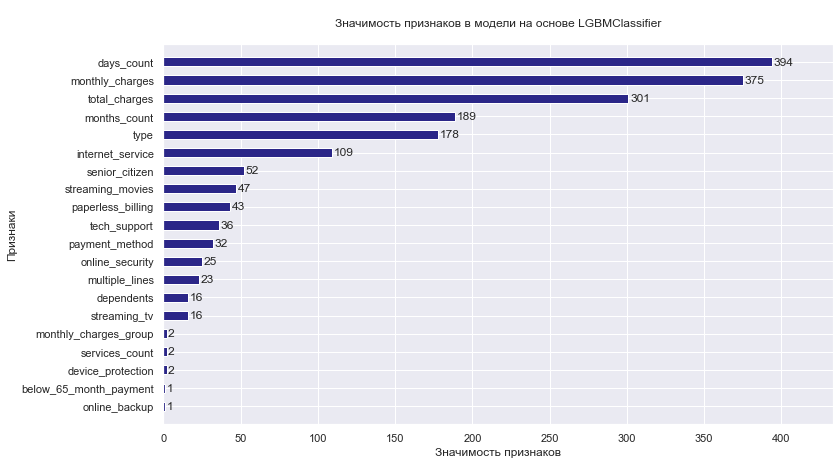

In [96]:
# просмотр значимости признаков для модели на основе градиентного бустинга LGBMClassifier
plot_importance(
    grid_search_lgb.best_estimator_.named_steps.model, 
    title='\nЗначимость признаков в модели на основе LGBMClassifier\n',
    xlabel='Значимость признаков', 
    ylabel='Признаки',
    figsize=(12, 7),
    height=0.5
);

> * Модель на основе *LGBMClassifier* на обучающей выборке после подбора гиперпараметров по показателю метрики *ROC-AUC* позволила достичь значения, равного `0.955`, незначительно уступив лучшей модели градиентного бустинга на основе *CatBoostClassifier*.
> * Тремя наиболее значимыми признаками по результатам обучения модели на основе *LGBMClassifier* стали `days_count` - количество дней в статусе клиента компании с даты заключения договора, `monthly_charges` - ежемесячные платежи независимо от типа оплаты и `total_charges` - общая сумма платежей клиента.

### Сравнительный анализ моделей

Оценим насколько успешно с поставленной задачей выявления нелояльных клиентов, то есть предсказанием класса `1` целевой переменной, справляется модель, обеспечившая лучшее значение метрики *ROC-AUC* по результатам обучения с подбором гиперпараметров на кросс-валидации.

Для этого визуализируем разделение вероятностей отнесения к классу `1` (ушедших клиентов) для обученной модели на основе *LGBMClassifier*.

In [97]:
%%time
# получение вероятностей принадлежности прогнозов к классу 1 (ушедших клиентов)
predict_proba = grid_search_lgb.best_estimator_.predict_proba(x_test)[:, 1]

CPU times: total: 0 ns
Wall time: 6.98 ms


In [98]:
# объединение вероятностей с истинными значениями целевого признака
df_probs = (
    pd.concat([y_test, pd.Series(predict_proba, index=y_test.index)], axis=1)
    .rename(columns={0: 'probs'})
)

In [99]:
# просмотр первых строк полученной таблицы
df_probs.head()

,client_off,probs
1571,0,0.477934
5848,0,0.063981
6395,1,0.262664
5930,0,0.058382
5134,1,0.744832


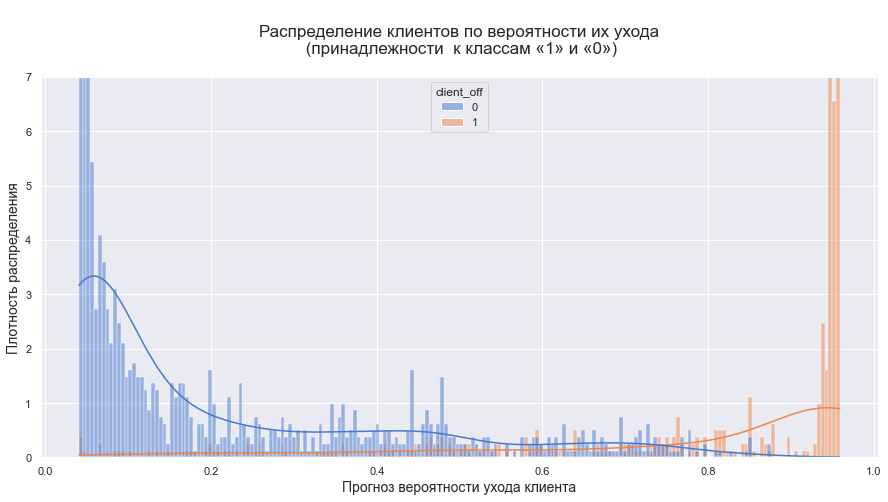

In [100]:
# построение графика распределение прогнозов по вероятности их отнесения к классу 1 (ушедших клиентов)
sns.set()
sns.set_palette(palette='muted')
fig = plt.figure(figsize=(15, 7))
ax = sns.histplot(data=df_probs, x='probs', hue='client_off', stat='density', kde=True, bins=200)
ax.set_ylim(0, 7)
ax.set_title('\nРаспределение клиентов по вероятности их ухода\n (принадлежности  к классам «1» и «0»)\n', fontsize=17)
ax.set_xlabel('Прогноз вероятности ухода клиента', fontsize=14)
ax.set_ylabel('Плотность распределения', fontsize=14)
plt.show();

Создадим сводную таблицу для сравнительного анализа обученных моделей.

In [101]:
# создание сводной таблицы по результатам обучения моделей
result_df = pd.DataFrame(
    [[round(best_rnd_roc, 3)],
     [round(roc_score_dm, 3)],
     [round(score_lr, 3)],
     [round(score_rf, 3)],
     [round(score_cb, 3)],
     [round(score_lg, 3)]],
    columns=['ROC-AUC'],
    index=['RandomPredict', 'Dummy', 'LogisticRegression', 'RandomForest', 'CatBoostClassifier', 'LGBMClassifier']
)

# просмотр полученных результатов
result_df

,ROC-AUC
RandomPredict,0.538
Dummy,0.503
LogisticRegression,0.849
RandomForest,0.863
CatBoostClassifier,0.956
LGBMClassifier,0.955


Для наглядного графического сравнения различных алгоритмов создадим вспомогательную функцию *algo_comparison()*.

In [102]:
# функция визуального сравнение моделей
def algo_comparison(x_vals:pd.Series, y_vals:pd.Index, title:str, x_label:str, v_line:float) -> None:
    """
    input: x_vals (pandas.Series)  - значения метрики ROC-AUC по различным сравниваемым моделям
           y_vals (pandas.Index) - индексы значений (наименования моделей)
           title (str)             - наименование графика
           x_label (str)           - подпись к оси х
           v_line (numpy.float64)  - значение границы по метрике для dummy-модели
    output: None
    description: Функция принимает input параметры и строит столбчатую диаграмму по значениям метрик ROC-AUC
                 различных моделей для их визуального сравнения с границей, определённой по dummy-модели
    """
    sns.set()
    sns.set_palette(palette='deep')
    fig = plt.figure(figsize=(10, 5))
    
    ax = sns.barplot(x=x_vals, y=y_vals)
    ax.set_yticklabels(y_vals, fontsize=13)
    ax.set_title(f'\n{title}\n', fontsize=17)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/v_line)
        x = p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x+0.04, y-0.25), ha='center', fontsize=13)
    
    plt.xlabel(x_label, fontsize=13)
    plt.axvline(v_line, color = 'r', linestyle = '--')
    plt.show();
    
    return None

Воспользуемся функцией *algo_comparison()*, чтобы построить график сравнения метрик различных моделей.

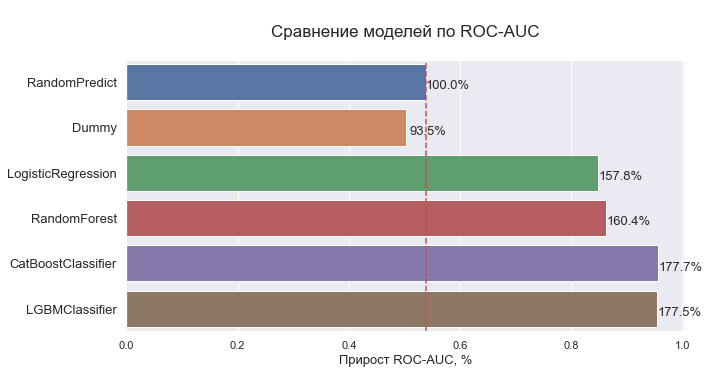

In [103]:
# сравнение метрик различных моделей по метрике RMSE с помощью функции algo_comparison()
algo_comparison(
    result_df['ROC-AUC'],
    result_df.index,
    'Сравнение моделей по ROC-AUC',
    'Прирост ROC-AUC, %',
    result_df.loc['RandomPredict', 'ROC-AUC']
)

> * На графике распределения прогнозов по вероятности их отнесения к классу `1` (ушедших клиентов) видно, что модель в целом достаточно хорошо разделяет вероятности отнесения прогнозов к одному из двух целевых классов, но при также во всём диапазоне вероятностей от `0.0` до `1.0` присутсвуют объекты на которых модель ошибается в прогнозах.
> * На обучающей выборке лучший результат показала модель на основе *CatBoostClassifier*, на втором месте с незначительным отставанием оказалась модель на основе *LGBMClassifier*, на третьем - *RandomForest*.

### StackingClassifier

Проверим можно ли повысить качество работы, взяв три лучшие модели, которыми по результатам сравнительного анализа стали *RandomForest*, *CatBoostClassifier* и *LGBMClassifier*, объединив их в единую модель с помощью мета-классификатора в роли которого будет выступать логистическая регрессия.

In [104]:
# класс для стекинга моделей и создания на их основе мета-классификатора
class StackingClassifier(BaseEstimator, ClassifierMixin):
    """Класс объединения моделей в ансамбль для получения финального прогноза.
    
    Parameters:
    ----------
    meta_classifier: (LogisticRegression)        - модель, используемая в качестве мета-классификатора
    models: (CatBoostClassifier, LGBMClassifier) - модели, из которых будет сотавлен стек
    cv: (int)                                    - количество фолдов на кросс-валидации
    threshold: (float)                           - значение порога по которому будет происходить разделение вероятностей 
                                                   на классы
    """
    
    def __init__(self, meta_classifier:LogisticRegression, models, cv=5, threshold=0.5):
        self.meta_classifier=meta_classifier
        self.models = models
        self.threshold = threshold
        self.cv=cv
        self.kf = KFold(n_splits=self.cv)
        self.scores = []
    
    def fit(self, X:tuple, y:pd.Series) -> None:
        """Обучение стекинговых моделей под общим мета-классификатором.
        Parameters
        ----------
        X : (tuple)   - обучающий набор данных
        y (pd.Series) - значения целевой переменной
        Returns
        -------
        None :
        """
        models_to_train = [clone(model) for model in self.models]
        X_new = np.zeros((y.shape[0], len(models_to_train)))

        for train_indexes, test_indexes in self.kf.split(y):
            for t, clf in enumerate(self.models):
                clf.fit(X[t].iloc[train_indexes], y.iloc[train_indexes])
                X_new[test_indexes, t] = clf.predict_proba(X[t].iloc[test_indexes])[:, 0]
                
        self.meta_classifier.fit(X_new, y)
        self.scores.append(roc_auc_score(y, self.meta_classifier.predict_proba(X_new)[:, 1]))
        return self
        
    def predict_proba(self, X:tuple) -> np.ndarray:
        """Получение прогнозов от обученной модели в виде вероятностей.
        Parameters
        ----------
        X : (tuple)   - набор данных для получения прогнозов на обученной модели
        Returns
        -------
        probs (np.ndarray) - вероятности отнесения к одному из классов:
        """
        X_new = np.zeros((X[0].shape[0], len(self.models)))
        
        for t, clf in enumerate(self.models):
            X_new[:, t] = clf.predict_proba(X[t])[:, 0]
            
        self.probs = self.meta_classifier.predict_proba(X_new)
        return self.probs
    
    def predict(self, X:tuple) -> np.ndarray:
        """Получение прогнозов от обученной модели в виде классов.
        Parameters
        ----------
        X : (tuple)   - набор данных для получения прогнозов на обученной модели
        Returns
        -------
        preds (np.ndarray) - вероятности отнесения к одному из классов:
        """
        self.preds = (self.predict_proba(X)[:, 1] > self.threshold) * 1
        return self.preds
    
    def best_score(self) -> float:
        """Получение лучшего значения метрики на кросс-валидации.
        Parameters
        ----------
        None : 
        Returns
        -------
        max_score (float) - лучшее значение метрики на кросс-валидации
        """
        self.max_score = max(self.scores)
        return self.max_score

In [105]:
# создание модели для мета-классификатора
meta_classifier = LogisticRegression(max_iter=1000, C=1, random_state=RND, n_jobs=-1)

In [106]:
# получим список параметров CatBoostClassifier и обновим у него значение iterations
params = model_cb.get_params()
params['iterations']=best_iter

In [107]:
# пересоздадим модель на обновлённых гиперпараметрах
model_cb = CatBoostClassifier(**params)

# создание экземпляра класса мета-классификатора
classifier = StackingClassifier(
    meta_classifier, 
    [model_cb, grid_search_lgb.best_estimator_]
)

In [108]:
start_time = datetime.datetime.now()

# обучение мета-классификатора
classifier.fit((X_train, X_train), y_train)

learning_time_mc = (datetime.datetime.now()-start_time).seconds

0:	learn: 0.8960986	total: 24.5ms	remaining: 35.6s
500:	learn: 0.9597194	total: 17s	remaining: 32.4s
1000:	learn: 0.9674234	total: 35.1s	remaining: 16s
1455:	learn: 0.9727175	total: 51.5s	remaining: 0us
0:	learn: 0.9059871	total: 25.3ms	remaining: 36.8s
500:	learn: 0.9573579	total: 17.7s	remaining: 33.8s
1000:	learn: 0.9661744	total: 35.1s	remaining: 15.9s
1455:	learn: 0.9727703	total: 49.8s	remaining: 0us
0:	learn: 0.9134245	total: 12.2ms	remaining: 17.7s
500:	learn: 0.9597935	total: 16.8s	remaining: 32s
1000:	learn: 0.9662107	total: 33.8s	remaining: 15.4s
1455:	learn: 0.9714950	total: 50s	remaining: 0us
0:	learn: 0.8996320	total: 26.2ms	remaining: 38.1s
500:	learn: 0.9591487	total: 15.8s	remaining: 30.2s
1000:	learn: 0.9662461	total: 34s	remaining: 15.4s
1455:	learn: 0.9718794	total: 49.4s	remaining: 0us
0:	learn: 0.8990407	total: 25.8ms	remaining: 37.5s
500:	learn: 0.9609265	total: 17.8s	remaining: 34s
1000:	learn: 0.9684975	total: 35s	remaining: 15.9s
1455:	learn: 0.9733267	total: 

Оценим количество времени, затраченного на обучение мета-классификатора.

In [109]:
# оценка времени обучения StackingClassifier
print_tab_row(
    'Количество времени, затраченного на обучение StackingClassifier, секунд:', 
    learning_time_mc,
    total_width=85,
    col_1_format='| {: <70}|',
    col_2_format='     {: >d} |'
)

-------------------------------------------------------------------------------------
| Количество времени, затраченного на обучение StackingClassifier, секунд:|     253 |
-------------------------------------------------------------------------------------


In [110]:
# получение  метрики ROC-AUC на кросс-валидации на обучающих данных для StackingClassifier
print_tab_row(
    'ROC-AUC на тестовых данных для StackingClassifier:', 
    classifier.best_score(),
    total_width=85,
    col_1_format='| {: <70}|',
    col_2_format='{: >10.5f} |'
)

-------------------------------------------------------------------------------------
| ROC-AUC на тестовых данных для StackingClassifier:                    |   0.95653 |
-------------------------------------------------------------------------------------


Стекинг моделей под общим мета-классификатором не привёл к качественному улучшению метрики `ROC-AUC` по сравнению с лучшей моделью, которой по результатам сравнительного анализа стал *CatBoostClassifier*. При этом для обучения мета-классификатора дополнительно нужно затратить время на соотвествующие вычисления.

Исходя из сказанного выше, за рабочую модель для решения поставленной задачи принимаем *CatBoostClassifier*. Определим для него значение метрики качества `ROC-AUC` на тестовой выборке.

In [111]:
# получение результатов работы лучшей модели на основе CatBoostClassifier на тестовой выборке
roc_score_lg_test = print_scores_on_test(
    model_cb, 
    x_test, 
    y_test, 
    params_cb, 
    'CatBoostClassifier'
)

-------------------------------------------------------------------------------------
| Параметры модели:                                                     |           |
|	depth                                                           |         4 |
|	learning_rate                                                   |      0.02 |
-------------------------------------------------------------------------------------
| ROC-AUC на тестовых данных для CatBoostClassifier:                    |   0.94597 |
-------------------------------------------------------------------------------------
| Значение F1-меры:                                                     |   0.82127 |
-------------------------------------------------------------------------------------
| Значение Accuracy:                                                    |   0.91028 |
-------------------------------------------------------------------------------------


> * На обучающей выборке для модели *StackingClassifier*, полученной путём объединения в мета-классификатор двух лучших моделей, которыми по результатам сравнительного анализа стали *CatBoostClassifier* и *LGBMClassifier*, значение метрики *ROC-AUC* составило `0.970`.
> * Несмотря на то, что стекинг двух лучших моделей по результатам подобра гиперапараметров на кросс-валидации в данной задаче приводит к улучшению метрики `ROC-AUC` с `0.956` до `0.970`, при этом требуются дополнительных продолжительные по времени вычисления.
> * По указанным в предыдущих пунктах причинам, за основную рабочую модель для решения поставленной задачи принимаем отдельную лучшую модель на основе *CatBoostClassifier*. На тестовой выборке `ROC-AUC` для выбранной модели на основе *CatBoostClassifier* составил `0.946`.

### График ROC-AUC

Построим график ROC-AUC для модели на основе *CatBoostClassifier*.

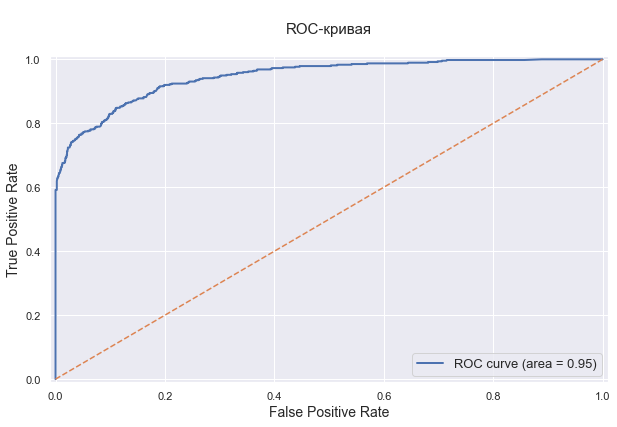

In [112]:
# получение данных для построения ROC-AUC графика
fpr, tpr, thresholds = roc_curve(y_test, grid_search_lgb.best_estimator_.predict_proba(x_test)[:, 1])
roc_auc_value = auc(fpr, tpr)

# построение графика ROC-AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve (area = %0.2f)' % (roc_auc_value))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('\nROC-кривая\n', fontsize=15)
plt.legend(loc='lower right', fontsize=13)
plt.show()

> * График *ROC-AUC* для предсказаний модели на тестовой выборке для модели на основе *CatBoostClassifier* значимо отличается от случайных предсказаний, которые представляет диагональная оранжевая линия.

### Анализ матрицы ошибок

Для сопоставления предсказаний и реальных значений целевой переменной построим матрицу ошибок (*confusion matrix*) – таблицу, в которой для результатов работы модели на основе *CatBoostClassifier* будут подсчитаны все возможные комбинациями прогнозируемых и фактических значений.

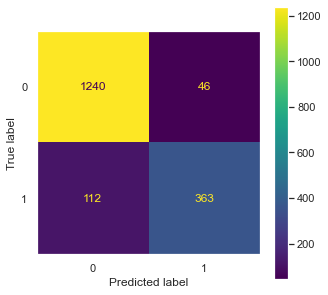

In [113]:
# получение матрицы ошибок для модели на основе CatBoostClassifier
preds = (model_cb.predict_proba(x_test)[:, 1] > 0.5).astype('int64')

fig, _ = plt.subplots(nrows=1, figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

cm = confusion_matrix(y_test, preds, labels=grid_search_lgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_lgb.classes_)
disp.plot(ax=ax);

Проанализируем матрицу ошибок по полученным значениям:
* всего в тестовой выборке, по которой была построена матрица ошибок, содержался `1761` объект;
* так как по целевой переменной выборка имеет дибаланс, заключающийся в том, что ушедших клиентов `27%`, то в идеальном случае модель должна была предсказать для тестовой выборки `≈1286` объектов класса `0` (сохраняющих лояльность клиентов) и `≈475` объектов класса `1` (ушедших клиентов);
* фактически по прогнозам модели на основе *CatBoostClassifier* имеем `1244` значений *True Negative* (`TN`), когда клиент остаётся лояльным и модель предсказала его как сохраняющего лояльность (корректно отнесла к классу `0`);
* `362` значение *True Positive* (`TP`), когда клиент расторг договор и модель смогла корретно это спрогнозировать (отнесла клиента к классу `1`);
* `42` ошибки первого рода *False Positive* (`FP`), когда модель лояльного клиента пометила как нелояльного (ошибочно отнесла клиента к классу `1`);
* `113` ошибок второго рода *False Negative* (`FN`), когда модель нелояльного клиента пометила как лояльного (ошибочно отнесла к классу `0`).

С точки зрения бизнеса все ошибки модели можно интерпретировать по метрикам *precision* и *recall* следующим образом:
*  за минимизацию ложноположительных прогнозов (`FP`) - т.е. ошибочно отмеченных нелояльными лояльных клиентов отвечает точность (*precision*) чем выше которая, тем меньше ошибок первого рода будет в прогнозах модели;
*  за минимизацию ложноотрицательных прогнозов (`FN`) - т.е. ошибочно отмеченных лояльными нелояльных клиентов отвечает полнота (*recall*) чем выше которая, тем меньше ошибок второго рода будет в прогнозах модели.

Можно предположить (но требуется уточнение со стороны бизнеса), что более критичными в задаче прогнозирования оттока клиентов будут ошибки второго рода (`FN`), когда мы не смогли распознать нелояльного клиента и предпринять меры для его сохранения в статусе клиента компании. Подобных ошибок в полученной модели в `1.57` раза меньше, чем менее существенных ошибок первого рода (`FP`).

Как было сказано выше, за минимизацию ошибок второго рода (`FN`) отвечает полнота *recall*. Поэтому, построим график зависимости полноты *recall* и точности *precision* в зависимости от выбранного порога классификации.

Для построения подобного графика создадим две вспомогательные функции *get_proba_df()* - для формирования данных о зависимости *precision*, *recall* и *f1* от порога *threshold* в диапазоне вероятностей от `0` до `1` и *show_scores()* - непосредственно для построения самого графика.

In [114]:
# функция формирования датафрейма со значениями метрик precision, recall и f1 в диапазоне порогов
def get_proba_df(model:Pipeline, x_test:pd.Series, y_test:pd.Series) -> pd.DataFrame:
    """
    input: model (classifier)            - обученная модель
           x_test (pandas.Series)        - значения recall для оси Y
           y_test (pandas.Series)        - значения precision для оси Y
           f1_vals (pandas.Series)       - значения F1 метрики для оси Y
    output: df_scores (pandas.DataFrame) - датафрейм с метриками precision, recall и f1 в диапазоне порогов threshold
    description: Функция принимает input параметры и возвращает датафрейм с метриками precision, recall и f1 в диапазоне
                 порогов threshold
    """
    probabilities_valid = model.predict_proba(x_test)
    probabilities_one_valid = probabilities_valid[:, 1]

    scores = []
    for threshold in np.arange(0.1, 0.9, 0.01):
        predicted_valid = probabilities_one_valid > threshold
        precision = precision_score(y_test, predicted_valid)
        recall = recall_score(y_test, predicted_valid)
        f1 = f1_score(y_test, predicted_valid)

        scores.append([threshold, precision, recall, f1])
        
    df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1'])
    return df_scores

In [115]:
# функция построения графика зависимости precision, recall, F1 от порога threshold
def show_scores(x_vals:pd.Series, 
                recall_vals:pd.Series, 
                precision_vals:pd.Series, 
                f1_vals:pd.Series, 
                title:str, 
                cross_val:float) -> None:
    """
    input: x_vals (pandas.Series)      - значения порога threshold для оси X
           recall_vals (pandas.Series) - значения recall для оси Y
           precision (pandas.Series)   - значения precision для оси Y
           f1_vals (pandas.Series)     - значения F1 метрики для оси Y
           title (str)                 - строка для названия графика
           cross_val (float)           - значение, в котором происходит пересечение графиков precision, recall и F1
    output: None
    description: Функция принимает input параметры и строит график зависимости precision, recall, F1 от 
                 порога threshold
    """
    fig, axes = plt.subplots(1,1, figsize=(12, 6))
    
    axes.plot(x_vals, recall_vals, label='recall', color='#016795', linewidth=3)
    axes.plot(x_vals, precision_vals, label='precision', color='#FF9408', linewidth=3)
    axes.axvline(x=cross_val, label=cross_val, color='#FE019A', linestyle='--')
    axes.fill_between(x_vals, f1_vals, alpha=0.35, label='threshold')
    
    plt.title(f'\nГрафик зависимости precision, recall, F1 от порога threshold\n для модели на основе {title}\n', 
              fontsize=17)
    plt.xlabel('threshold', fontsize=14)
    plt.ylabel('precision / recall', fontsize=14)
    plt.legend(loc='lower left', fontsize=14)
    plt.ylim([0.5, 1])
    plt.show();
    
    return None

In [116]:
# получение датафрейма со значениями метрик и просмотр его первых строк
df_scores = get_proba_df(grid_search_lgb, x_test, y_test)
df_scores.head(5)

,threshold,precision,recall,f1
0,0.10,0.440758,0.978947,0.607843
1,0.11,0.454367,0.974737,0.619813
2,0.12,0.463000,0.974737,0.627797
3,0.13,0.476190,0.968421,0.638446
4,0.14,0.484211,0.968421,0.645614


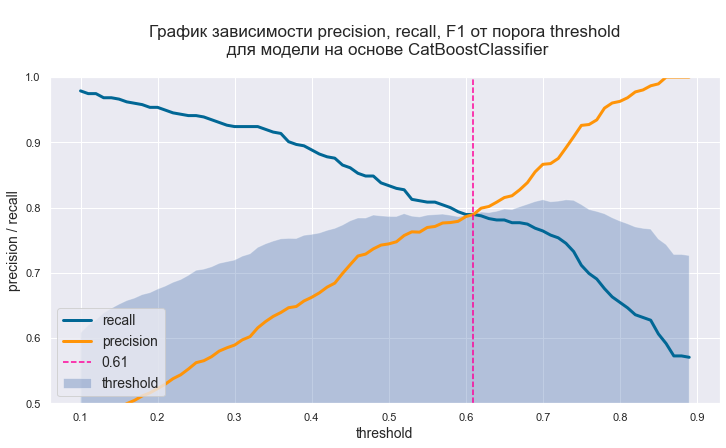

In [117]:
# построение графика зависимости precision, recall, F1 от порога threshold для CatBoostClassifier
show_scores(
    df_scores['threshold'], 
    df_scores['recall'], 
    df_scores['precision'], 
    df_scores['f1'], 
    'CatBoostClassifier',
    0.61
)

Анализируя полученный график, можно отметить, что для лучшего решения бизнес-задачи по прогнозированию оттока клиентов и минимизации ошибок имеет смысл смещение порога отнесения к одному из классов немного правее до значения, равного `0.61`, в котором происходит пересечение графиков *precision* и *recall*.

Проверим на основе матрицы ошибок к какому результату приведёт предложенное увеличение порогового значения `threshold` у модели на основе *CatBoostClassifier* с дефолтного `0.5` до `0.61`.

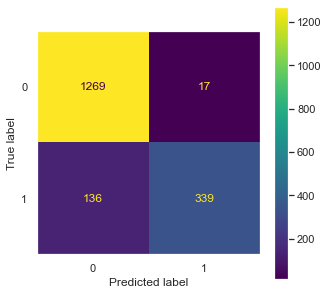

In [118]:
# получение матрицы ошибок для модели на основе CatBoostClassifier
preds = (model_cb.predict_proba(x_test)[:, 1] > 0.61).astype('int64')

fig, _ = plt.subplots(nrows=1, figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(False)

cm = confusion_matrix(y_test, preds, labels=grid_search_lgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_lgb.classes_)
disp.plot(ax=ax);

В результате изменения порогового значения классификации c `0.5` до `0.61`:
* общее количество ошибок модели возросло на `4` единицы со `155` до `156`;
* количество *True Negative* (`TN`) возросло с `1244` до `1264`;
* количество *True Positive* (`TP`) сократилось с `361` до `333`;
* количество предположительно менее значимых ошибок первого рода (`FP`) сократилось с `42` до `22`;
* количество наиболее значимых ошибок второго рода (`FN`) возросло с `113` до `134`.

Предположение о том, что ошибки первого рода, когда лояльный клиент предсказывается моделью как нелояльный, являются менее значимыми по сравнению с ошибками второго рода, когда нелояльный клиент классифицируется как лояльный построено на том, что потеря клиента обходится компании дороже, чем средства, направленные на удержание клиента. По этой причине лучше больше пометить лояльных клиентов нелояльными и затратить средства на их удержание, чем пропустить большее количество нелояльных клиентов, из-за того, что модель не смогла их определить.

Как упоминалось ранее, это требует уточнения со стороны бизнеса. На данном же этапе смещение порогового значения классификации представляется нецелесообразным.

> * На основе исходного датасета сформированы обучающая и тестовая выборки в соотношении `3:1`. В обучающей и тестовой выборках проверено соотвествие баланса классов исходной выборке.
> * В качестве контрольной метрики определена функция нахождения метрики *ROC-AUC*.
> * За константную модель принято лучшее значение *ROC-AUC* на основе случайно сгенерированных на `10000` итераций «предсказаний», которое составило `0.537`.
> * Проведено обучение 4 видов моделей машинного обучения:
>  - Логистической регрессии
>  - Случайного леса
>  - *CatBoostClassifier*
>  - *LightGBMClassifier*
> * Наилучший результат по значению метрики *ROC-AUC* на обучающей выборке, равный `0.956`, продемонстрировала модель градиентного бустинга на основе *CatBoostClassifier*. На втором месте *LightGBMRClassifier* со значением метрики *ROC-AUC*, равным `0.955`, на третьем - случайный лес с показателем *ROC-AUC*, равным `0.863`.
> * Тремя наиболее значимыми признаками по результатам обучения модели на основе *CatBoostClassifier* стали `days_count` - количество дней в статусе клиента компании с даты заключения договора, `internet_service` - варианты подключения интернет-соединения и `type` - тип оплаты за услуги.
> * Тремя наиболее значимыми признаками по результатам обучения модели на основе *LGBMClassifier* стали `days_count` - количество дней в статусе клиента компании с даты заключения договора, `monthly_charges` - ежемесячные платежи независимо от типа оплаты и `total_charges` - общая сумма платежей клиента.
> * Попытка объединения двух лучших моделей на основе *LGBMClassifier* и *CatBoostClassifier* в единую модель с помощью мета-классификатора в роли которого выступила логистическая регрессия, привела к улучшению метрики `ROC-AUC` с `0.956` до `0.970`, но потребовала при этом дополнительных продолжительных по времени вычислений. По указанной причине её использование признано нецелесообразным.
> * За основную рабочую модель для решения поставленной задачи принят *CatBoostClassifier*. На тестовой выборке `ROC-AUC` для данной модели составил `0.946`, `F1`-мера `0.824`, `Accuracy` - `0.912`.
> * По построенному графику *ROC-AUC* для предсказаний модели на тестовой выборке для модели на основе *CatBoostClassifier* сделано заключение о его значимом отличии от случайных предсказаний.
> * Анализ матрицы ошибок по предсказанным значениям целевой переменной для модели на основе *CatBoostClassifier* позволил сделать вывод о том, что полученная по результатам обучения модель чаще совершает ошибки второго рода (*FN*), чем первого (*FP*), что с точки зрения решаемой бизнес-задачи хуже обратной ситуации, так как в данном случае происходит большое количество пропусков нелояльных клиентов.
> * Построен график зависимости *precision*, *recall* и *f1* от порога классификации *threshold* в диапазоне вероятностей от `0` до `1` и высказано предположение о целесообразности смещения порога правее до значения `0.61`, которое является точкой пересечения графиков *precision*, *recall* и *f1*.
> * Проведённый после смещения порога повторный анализ обновлённой матрицы ошибок показал вероятную нецелесообразность такого решения, так как вместе с общим незначительным увеличением количества ошибок с `155` до `156` одновременно происходит рост наиболее значимых ошибок второго рода (`FN`) со `113` до `134`. Уточнить справедливость данного вывода необходимо у представителей бизнеса.

## Общие выводы

> 1. Полученные в файлах `contract.csv`, `internet.csv`, `personal.csv` и `phone.csv` данные о клиентах телеком-компании и используемых ими сервисах были успешно загружены и проанализированы:
>    * для удобства работы и последующего анализа данных все таблицы из четырёх файлов объединены в общий датафрейм по их индексам `customerID`;
>    * в полученной сводной таблице нарушения змеиного стиля в названиях столбцов устранены преобразованием названий атрибутов из `CamelCase` в `snake_case`;
>    * установлено, что данные телекоммуникационной компании о клиентах представлены за период `6` лет и `3` месяца - с `октября 2013` года по `февраль 2020`;
>    * отток клиентов зафиксирован в последние четыре месяца и происходил по первым числам каждого месяца, что ставит вопрос о корректности данных по этому признаку и необходимости её уточнения;
>    * на основании данных о дате расторжения контракта сформирован целевой признак бинарного типа `client_off`, представленный двумя метками: `0` - клиент не ушёл, `1` - клиент расторг договор;
>    * созданы два дополнительных признака в виде `days_count` - общего количества дней, в течение которых клиент пользуется/пользовался услугами оператора и `months_count`- общего количества месяцев, в течение которых клиент являлся или продолжает являться пользователем услуг;
>    * проведена оценка распределения значений признаков, которая позволила установить:
>        * целевой признак `client_off` имеет дисбаланс классов среди ушедших и продолжающих пользоваться услугами клиентов с соотношением `26.5%` и `73.5%` соотвественно;
>        * в распределениях количественных признаков таких как `days_count` - количество дней в статусе клиента, `months_count` - количество месяцев в статусе клиента, `monthly_charges` - ежемесячные платежи и `total_charges` - общая сумма платежей, несмотря на значимые отличия в средних и медианных значениях для исследуемых групп, чёткого разделения по целевым классом не наблюдается;
>        * установлена очень сильная корреляция в `0.999` между `days_count` - общим количеством дней в статусе клиента `months_count`- общим количеством месяцев, а также сильная корреляция со значением `0.825` между ежемесячными платежами `monthly_charges` и общей суммой платежей `total_charges`, от которых пришлось избавиться на этапе обучения линейной модели путём удаления коррелирующих признаков;
>        * также проведён анализ распределений группы категориальных признаков по результатам которого установлено, что распределение ушедших и продолжающих оставаться пользователями компании клиентов по отдельным признакам неоднородно и присутствуют признаки с выраженными различиями, такие как `type` - тип оплаты за услуги или `paperless_billing` - получение клиентов электронного чека за услуги вместо бумажного, так и признаки в которых эти различия отсуствуют, такие как `gender` - пол клиента или незначительны, как в случае признака `partner` в виде наличия у клиента партнёра;
>    * в сводную таблицу признаков добавлена группа дополнительных атрибутов, которые сформированы из уже имеющихся, таких как:
>        * `services_count` - общее количество подключенных интернет-услуг у клиента;
>        * `monthly_charges_group` - категории по ежемесячным платежам;
>        * `months_group` - категории по количеству месяцев в статусе клиента;
>        * `below_20_months` - признак нахождения в статусе клиента менее `20` месяцев;
>        * `below_65_month_payment` - величина ежемесячных платежей менее `65`;
>        * `below_2000_total_charges` - общая сумма платежей менее `2000`.
>    * по результатам исследовательского анализа данных, а также их предаврительной обработки получен датафрейм, сотоящий их `28` признаков и `7043` объектов.



> 2. Выполнено обучение моделей, прогнозирующих вероятный отток клиентов, и проведён их сравнительный анализ:
>    * сформированы обучающая и тестовая выборки в соотношении `3:1`, которые проверены на соотвествие баланса классов исходной выборке;
>    * в качестве контрольной метрики определена функция нахождения метрики *ROC-AUC*;
>    * за константную модель принято лучшее значение *ROC-AUC*, составившее `0.537`, на основе случайно сгенерированных на `10000` итераций «предсказаний»;
>    * для модели на основе *DummyClassifier* получено значение метрики *ROC-AUC*, равное `0.504`;
>    * проведено обучение 4 различных типов моделей;
>        * логистической регрессии
>        * случайного леса
>        * градиентного бустинга на основе *CatBoostClassifier*
>        * градиентного бустинга на основе *LightGBMClassifier*
>    * лучший результат по значению метрики *ROC-AUC* на обучающей выборке, равный `0.956`, продемонстрировала модель градиентного бустинга на основе *CatBoostClassifier*. На втором месте *LightGBMClassifier* со значением метрики *ROC-AUC*, равным `0.955`, на третьем - случайный лес с показателем *ROC-AUC*, равным `0.863`;
>    * тремя наиболее значимыми признаками для модели на основе *CatBoostClassifier* стали `days_count` - количество дней в статусе клиента компании с даты заключения договора, `internet_service` - варианты подключения интернет-соединения и `type` - тип оплаты за услуги;
>    * тремя наиболее значимыми признаками для модели на основе *LGBMClassifier* стали `days_count` - количество дней в статусе клиента компании с даты заключения договора, `monthly_charges` - ежемесячные платежи независимо от типа оплаты и `total_charges` - общая сумма платежей клиента;
>    * объединение двух лучших моделей на основе *CatBoostClassifier* и *LGBMClassifier* в единую модель с помощью мета-классификатора в роли которого выступила логистическая регрессия, привела к улучшению метрики `ROC-AUC` с `0.956` до `0.970`, но потребовала при этом дополнительных продолжительных по времени вычислений и по этой причине её использование признано нецелесообразным;
>    * за основную рабочую модель для решения поставленной задачи принят *CatBoostClassifier*, который на тестовой выборке обеспечил значение метрики `ROC-AUC`, равное `0.946`, `F1`-меры `0.824`, `Accuracy` - `0.912`;
>    * по графику *ROC-AUC* для предсказаний модели на тестовой выборке для модели на основе *CatBoostClassifier* сделано заключение о его значимом отличии от случайных предсказаний;
>    * из анализа матрицы ошибок по предсказанным значениям целевой переменной для модели на основе *CatBoostClassifier* сделан вывод о том, что полученная по результатам обучения модель чаще совершает ошибки второго рода (*FN*), чем первого (*FP*), что предположительно хуже соотвествует решаемой бизнес-задаче;
>    * построен график зависимости *precision*, *recall* и *f1* от порога классификации *threshold* в диапазоне вероятностей от `0` до `1` и высказано предположение о целесообразности смещения порога правее до значения `0.61`, которое является точкой пересечения графиков *precision*, *recall* и *f1*;
>    * проведённый после смещения порога повторный анализ обновлённой матрицы ошибок показал вероятную нецелесообразность такого решения, так как вместе с общим незначительным увеличением количества ошибок с `155` до `156` одновременно происходит рост наиболее значимых ошибок второго рода (`FN`) со `113` до `134`. Уточнить справедливость данного вывода необходимо у представителей бизнеса.


> Финальной моделью, которую можно предстваить бизнесу как решение поставленной задачи, стала модель на основе *CatBoostClassifier* с параметрами:
> * `depth=4`,
> * `learning_rate=0.02`,
> * `iterations=1456`, 
> * `random_state=290822`,
> 
> обеспечившая значение **`ROC-AUC`** на тестовой выборке, равное **`0.946`**, **`F1`**-меры **`0.824`**, **`Accuracy`** - **`0.912`**.

## Отчёт по решению задачи

> 1. План решения задачи прогнозирования оттока клиентов у телеком компании состоял из следующих основных пунктов:
> 
>    * Получить данные и провести их исследовательский анализ. На основе аналитического подхода и анализа признаков попытаться выделить из них те, которые лучше всего объясняют отличия между двумя исследуемыми группами клиентов. Создать дополнительные признаки, которые могут улучшить качество прогнозирования оттока клиентов и оценить корреляцию между различными признаками. Определить целевую переменную.
>    * Сформировать обучающий и тестовый наборы данных в соотношении `3:1`, проверить соотношение целевых классов в полученных наборах, выделить из данных целевую переменную, создать функцию оценки качества моделей. В качестве метрики качества использовать `ROC-AUC`, которой должен быть больше значения `0.88`.
>    * Получить значение метрики качества по `ROC-AUC` для *baseline* модели в качестве которой будет выступать модель на основе предсказаний по случайным вероятностям и `Dummy`-модель. В качестве *baseline* модели из этих двух выбрать ту, которая обеспечит лучшее значение метрики `ROC-AUC`.
>    * Обучить на кросс-валидации с подбором гиперпараметров модели на основе логистической регрессии, случайного леса и градиентных бустингов *CatBoost* и *LightGBM*. Для каждой модели получить значение метрики качества по `ROC-AUC`.
>    * Свести все метрики обученных моделей в единую таблицу для наглядного анализа, провести сравнительный анализ моделей с целью выявления лучшей по метрике `ROC-AUC`. С помощью графика оценить распределение клиентов по вероятности их ухода  (принадлежности к классам `1` и `0`).
>    * Попробовать стекнуть две лучшие модели и посмотреть можно ли таким образом улучшить качество работы топовых моделей и если да, то насколько. Из четырёх обученных отдельных моделей и стекинговой модели выбрать ту, которая будет предложена бизнесу. Во время выбора опираться на качество моделей по `ROC-AUC` и скорость их обучения.
>    * Для выбранной модели построить график ROC-AUC. Оценить насколько он отличается от графика случайных предсказаний.
>    * Провести анализ работы модели на основе матрицы ошибок и посмотреть можно ли улучшить качество модели за счёт варьирования порога классификации.
>    * Сделать выводы. Предложить модель для решения задачи.
> 
>    Все пункты намеченного плана были последовательно выполнены. Задача в рамках поставленных по метрике качества условий решена.


> 2. Основная сложность, с которой столнулся в процессе реализации плана заключалась в том, чтобы получить лучшую метрику на кросс-валидации от самописной модели класса для стекинга моделей `StackingClassifier`. Сначала почему-то мне эта задача показалась очень сложной. Затем, по мере обдумывания стало приходить понимание, что ничего сложного в ней нет. Нашёл в учебных материалах в тренажёре задачу, где мы реализовывали кросс-валидацию без использования функционала `sclearn` на чистом `python`, убедился что мысль развивалась в нужном направлении и после этого уже не так сложно было перенести решение в код.


> 3. Учитывая, что всё решение задачи можно упаковать в 70 строк кода следующего вида:
> ```
> import pandas as pd
> import numpy as np
> import datetime
> from catboost import CatBoostClassifier
> from sklearn.metrics import roc_auc_score, accuracy_score
> from lightgbm import LGBMClassifier
> from sklearn.model_selection import train_test_split
> ```
> ```
> df_contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
> df_internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
> df_personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
> df_phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')
> ```
> ```
> df = (
>     df_contract.merge(df_internet, on =['customerID'], how='left')
>     .merge(df_personal, on =['customerID'], how='left')
>     .merge(df_phone, on =['customerID'], how='left')
> )
> ```
> ```
> df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = df.loc[df['TotalCharges'] == ' ', 'MonthlyCharges']
> df['TotalCharges'] = df['TotalCharges'].astype('float64')
> ```
> ```
> df['ClientOff'] = np.where(df['EndDate'] == 'No', 0, 1)
> ```
> ```
> df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
> df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d', errors='coerce')
> df['EndDate'] = df['EndDate'].fillna(df['EndDate'].max())
> df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
> ```
> ```
> df['DaysCount'] = (df['EndDate'] - df['BeginDate']).astype('timedelta64[D]').astype('int64')
> ```
> ```
> columns_with_missing_values = []
> for column in df.columns:
>     if df[column].isna().sum() > 0:
>         columns_with_missing_values.append(column)
> ```
> ```
> for column in columns_with_missing_values:
>     df[column] = df[column].fillna('No')
> ```
> ```
> X_small = df[['DaysCount', 'Type', 'InternetService']].copy()
> y = df['ClientOff']
> X_small_train, X_small_test, y_train, y_test = train_test_split(X_small, y, test_size=0.25, random_state=290822)
> cat_features_small = ['Type', 'InternetService']
> ```
> ```
> model = CatBoostClassifier(
>     cat_features=cat_features_small,
>     verbose=500,
>     eval_metric='AUC:hints=skip_train~false',
>     task_type='CPU',
>     iterations=1000,
>     thread_count=-1,
>     random_state=290822,
>     early_stopping_rounds=250
> )
> ```
> ```
> params_cb = {'learning_rate': [0.002, 0.02, 0.2], 
>     'depth': [3, 4, 5]
> }
> ```
> ```
> grid_search_cb = model.grid_search(
>     params_cb,
>     cv=5,
>     X=X_small_train, 
>     y=y_train,
>     partition_random_seed=290822,
>     stratified=True,
>     plot=False
> )
> ```
> ```
> print('Best AUC-ROC score', pd.Series(grid_search_cb['cv_results']['test-AUC-mean']).max())
> ```
>    
>    
>    и получить на этом коде значения метрик `ROC-AUC` на кросс-валидации и тесте примерно равные `0.90`, то основными шагами в решении задачи являются:
>    * импорт необходимых для работы библиотек;
>    * загрузка исходных данных;
>    * объединение данных в единый датафрейм;
>    * создание целевой переменной;
>    * создание дополнительного параметра в виде количества дней, в течение которых человек является или являлся клиентом компании;
>    * заполнение пропущенных значений;
>    * разделение выборки на обучающую и тестовую;
>    * обучение модели на основе *CatBoostClassifier*.


> 4. Согласно проведённому исследованию и полученному решению итоговой стала модель на основе *CatBoostClassifier* со следующими гиперпараметрами:
>    * `depth=4`;
>    * `iterations=1456`;
>    * `learning_rate=0.02`;
>    *  `random_state=290822`,
>    
>    которая позволила получить следующие показатели по метрикам качества:
>    * **`ROC-AUC`** на тестовой выборке - **`0.946`**;
>    * **`F1`**-мера на тестовой выборке - **`0.824`**;
>    * **`Accuracy`** на тестовой выборке - **`0.912`**.
>    


> 5. Обещал ответить на вопрос стоило ли вводить два напрямую коррелирующих между собой признака: `days_count` - количество дней в статусе клиента компании и `months_count` - количество месяцев в этой же роли, а также создавать на основе `months_count`другие признаки. Тесты показали, что это не имеет смысла. Эти действия не ведут к качественному улучшению метрик. *LGBMClassifier* так ещё и немного лучше отработал на данных без этих признаков. Остальные модели немного хуже.
>    
|                         |ROC-AUC months_count|ROC-AUC ~~months_count~~|
|:------------------------|-------------------:|-----------------------:|
|**RandomPredict**        | 0.538              |0.538                   |
|**Dummy**                |	0.503              |0.503                   |
|**LogisticRegression**   | 0.849              |0.844                   |
|**RandomForest**         |	0.863              |0.856                   |
|**CatBoostClassifier**   | 0.956              |0.956                   |
|**LGBMClassifier**       | 0.955              |0.956                   |


> 6. От ансамблирования лучших алгоритмов путём стекинга двух лучших моделей ожидал большего результата. Но, история получилась как с признаками выше. Прирост метрик минимальный, а количество вычислений существенно увеличивается. Предполагаю, что стекинг и блендинг имеет смысл использовать в соревнованиях на *Kaggle*, где даже незначительный прирост метрики может иметь значение. В практических задачах смысл их использования неочевиден.
